In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None) # display all columns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 2,GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import time
from scipy.stats import randint

# Sklearn
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, chi2, VarianceThreshold,SelectKBest,RFE,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer

# Import Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

---
# Import data

* df_train will be primary dataset. 
* df_test will be used for validation.

In [3]:
df_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [4]:
#Data Inspection
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
df_train.tail()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True


In [6]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [7]:
df_test.tail()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale
4276,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [9]:
# Numerical Summarization
df_train.describe(include='all')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


# train.csv - Personal records for about two-thirds (~8700, actual: 8693) of the passengers, to be used as training data.
***
* PassengerId: **CATEGORICAL**
    - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    - **Feature Engineering: Split into Groups**
***
* HomePlanet: **CATEGORICAL**
    - The planet the passenger departed from, typically their planet of permanent residence.
***
* CryoSleep: **CATEGORICAL**
    - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
***
* Cabin: **CATEGORICAL**
    - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - **Feature Engineering: Split into Deck/Number/Side**
***
* Destination: **CATEGORICAL**
    - The planet the passenger will be debarking to.
***
* Age: **NUMERICAL**
    - The age of the passenger.
***
* VIP: **CATEGORICAL**
    - Whether the passenger has paid for special VIP service during the voyage.
***
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: **NUMERICAL**
    - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - **Feature Engineering: Sum for Total Expenses**
***
* Name: **CATEGORICAL**
    - The first and last names of the passenger.
    - **Feature Engineering: Split into First Name and Last Name**
***
* Transported: **TARGET VARIABLE**
    - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


In [10]:
df_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

---
# Numerical EDA: Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

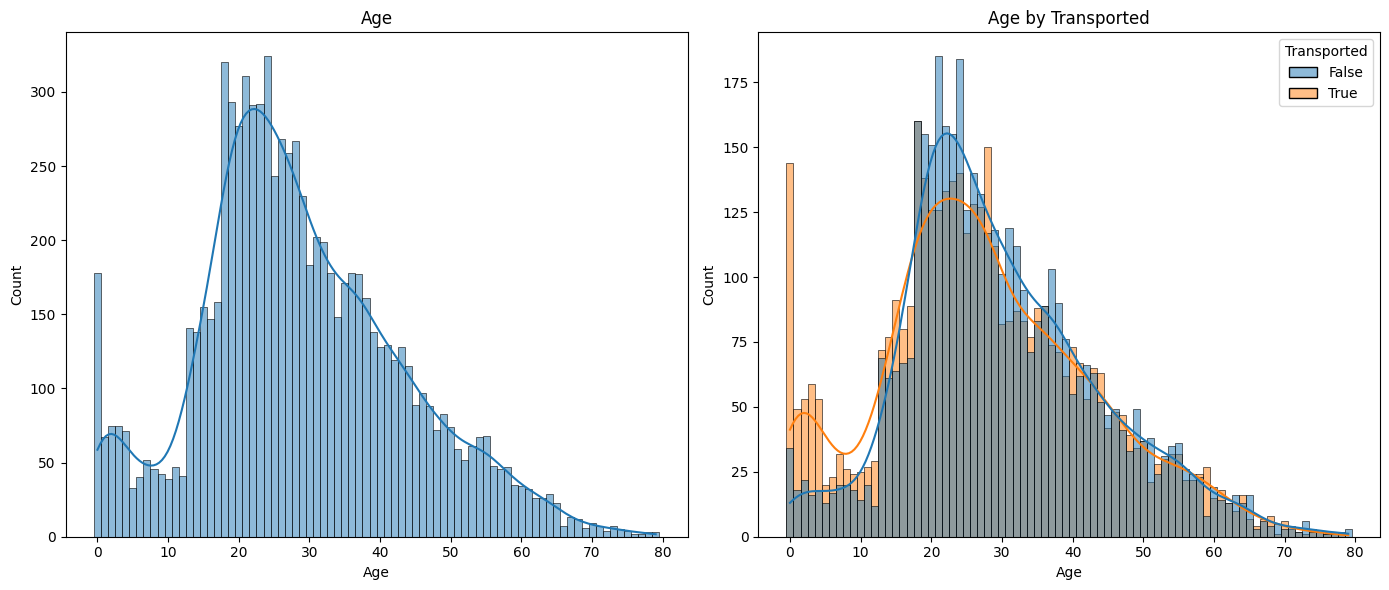

In [11]:
# Age Plot

# Create figure for 2 subplots 
fig, axs = plt.subplots(1,2,figsize=(14,6))

# Plot Age
sns.histplot(df_train,x='Age',discrete=True, kde=True, ax=axs[0])
axs[0].set_title('Age')

# Original graph
sns.histplot(data=df_train, x='Age', hue='Transported', discrete=True, kde=True, ax=axs[1])
axs[1].set_title('Age by Transported')

plt.tight_layout()
plt.show()

## Younger ages appear to be transported more frequently. 
* Feature Engineering: Create Age_Range bins to split into groups

# Expenses

* RoomService, FoodCourt, ShoppingMall, VRDeck, Spa: Plots are right-skewed and difficult to visualize due to outliers. Log-transformed data in middle allows better visualization of distribution, and boxplots on right allow interpretation of central tendency.

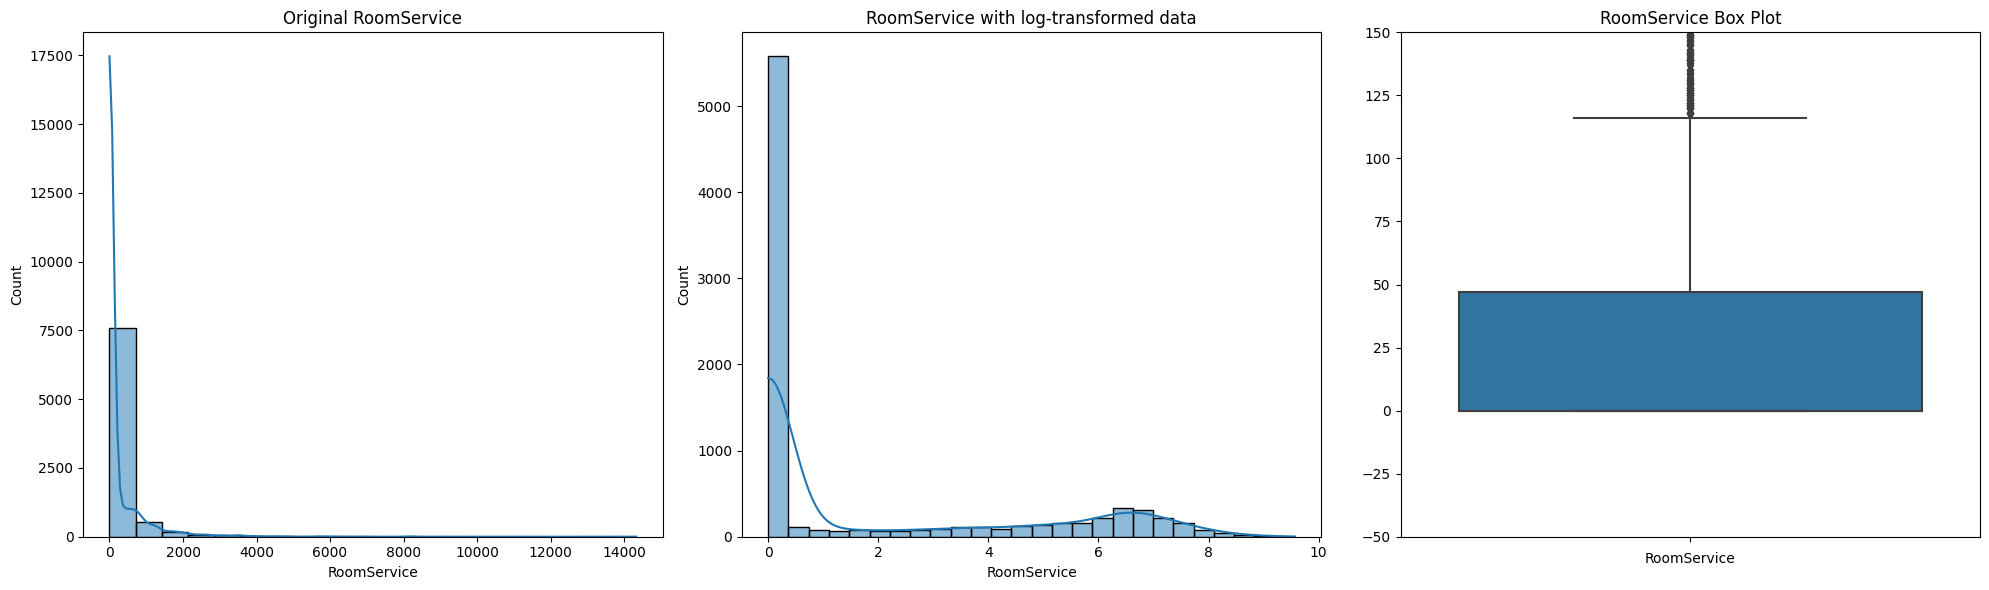

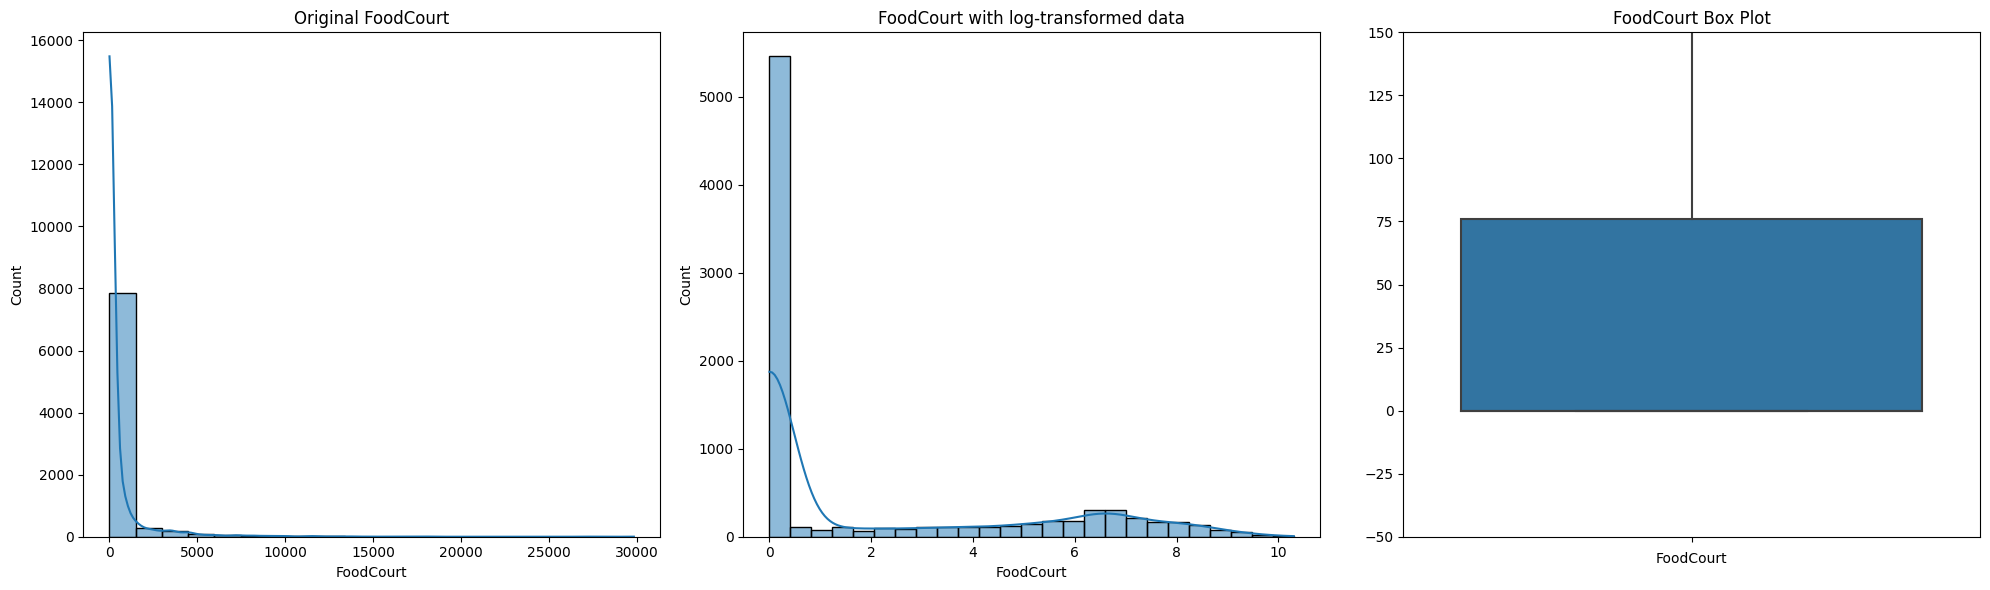

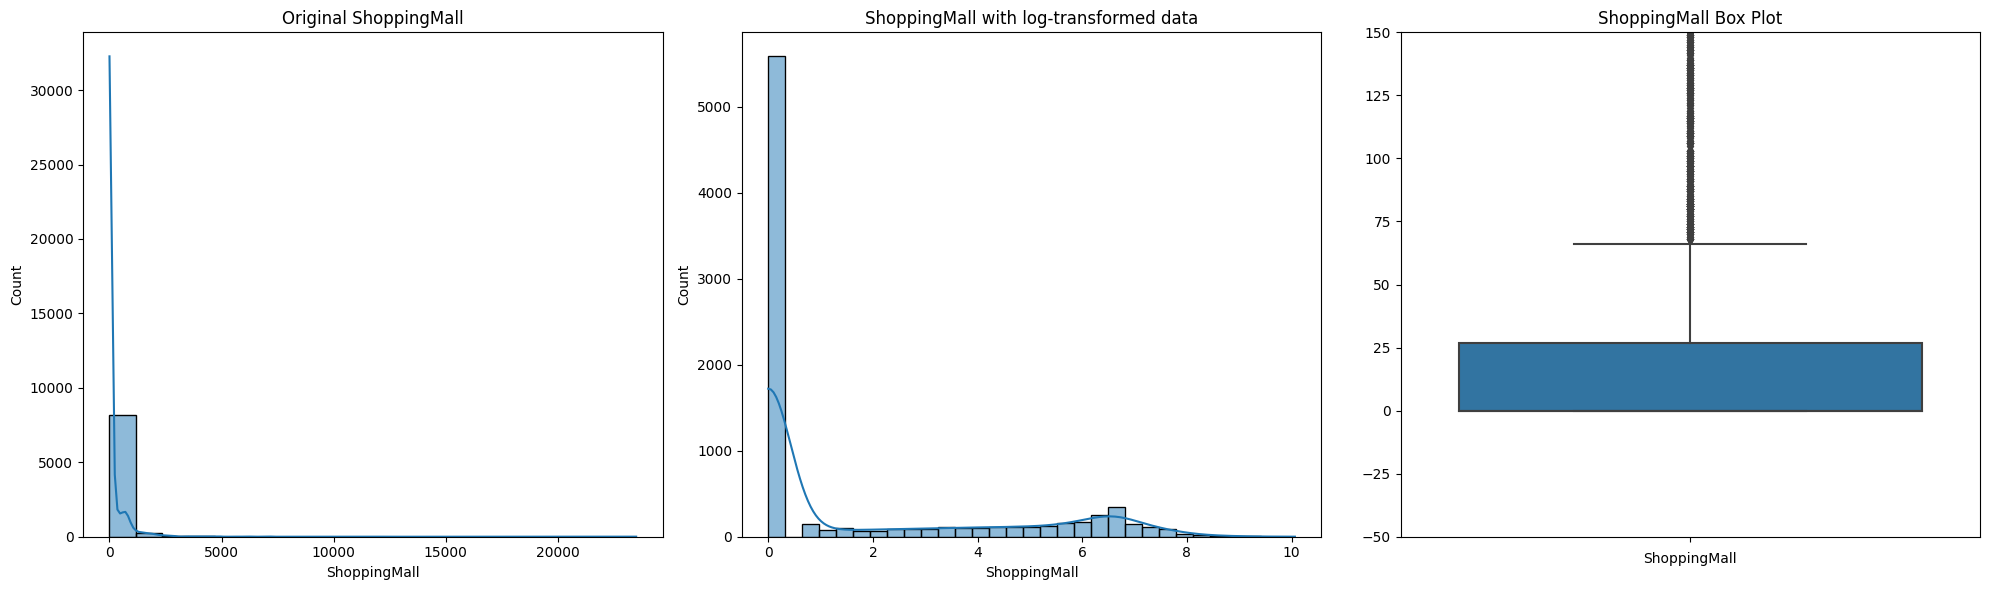

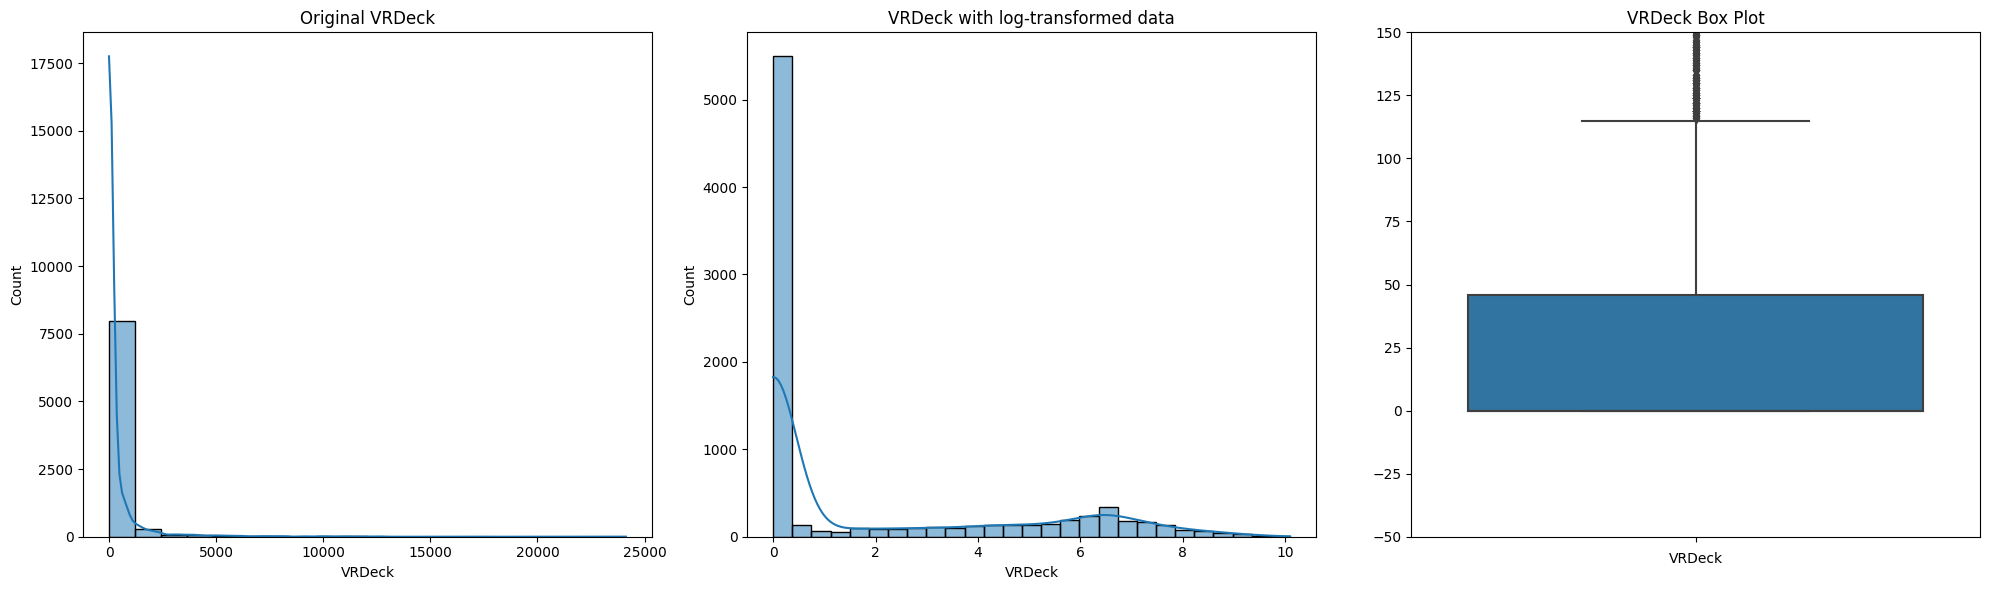

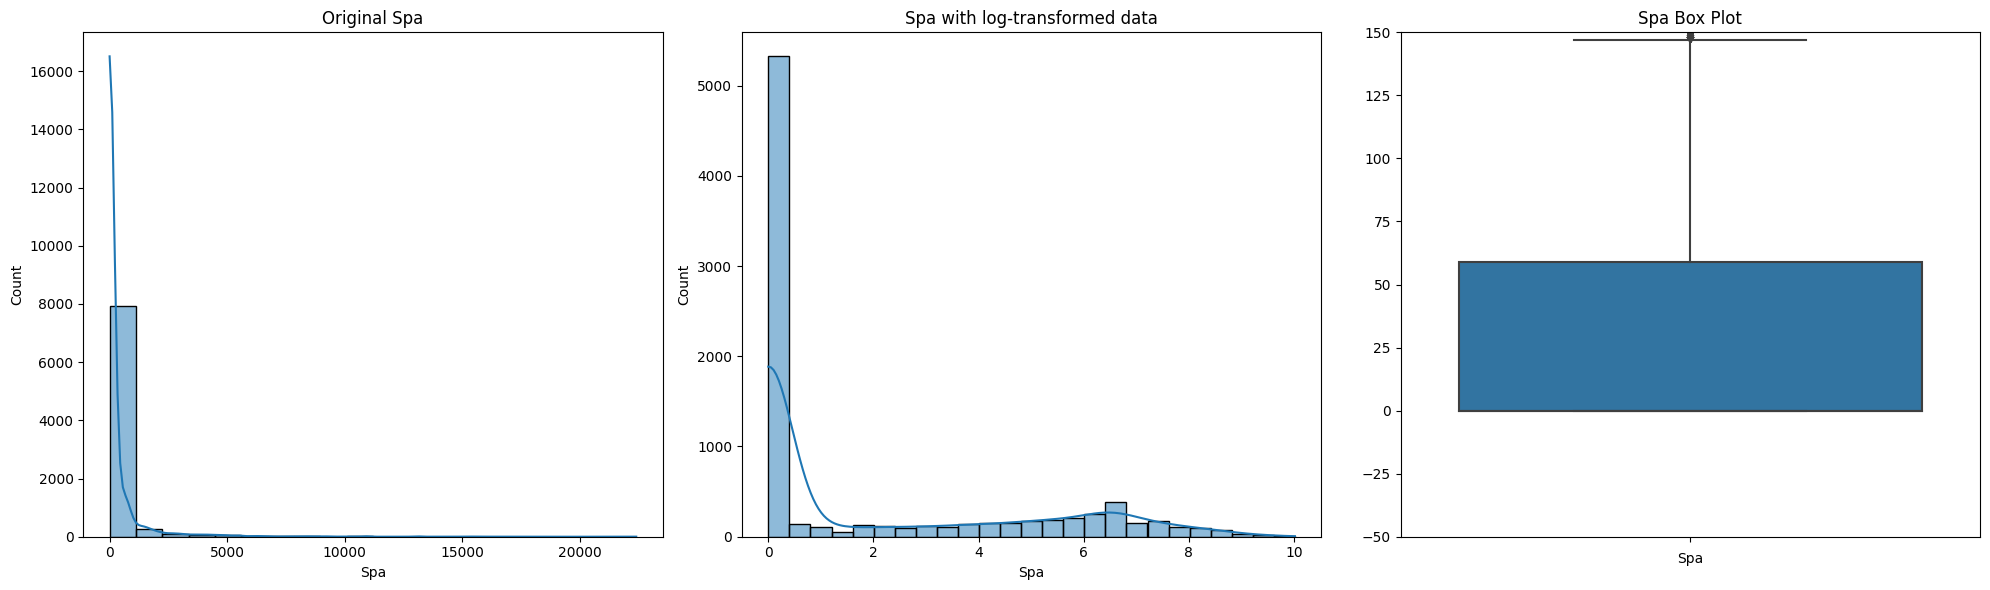

In [12]:
# Plot Expenses

for col in ['RoomService','FoodCourt','ShoppingMall','VRDeck','Spa']:
    # Create figure for 3 subplots 
    fig, axs = plt.subplots(1,3,figsize=(20,6))

    # Original graph
    sns.histplot(df_train[col], kde=True, ax=axs[0], bins=20)
    axs[0].set_title(f'Original {col}')

    # Log-transformed data
    sns.histplot(np.log1p(df_train[col]), kde=True, ax=axs[1])
    axs[1].set_title(f'{col} with log-transformed data')
    
    # Box Plot
    sns.boxplot(df_train[col], ax=axs[2])
    axs[2].set_title(f'{col} Box Plot')
    axs[2].set_ylim(-50,150)
    axs[2].set_xlabel(col)
    axs[2].set_xticklabels([])

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

Graphs indicate majority of passengers did not spend money on RoomService, FoodCourt, ShoppingMall, VRDeck, Spa.
* Feature Engineering: Create Total Expenses column and Log Transform data

# Expenses vs Transported

In [13]:
df_train_melt = df_train.melt(
    id_vars=['PassengerId','Transported'],
    value_vars=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],
    var_name='Category',
    value_name='Expense')
df_train_melt

,PassengerId,Transported,Category,Expense
0,0001_01,False,RoomService,0.0
1,0002_01,True,RoomService,109.0
2,0003_01,False,RoomService,43.0
3,0003_02,False,RoomService,0.0
4,0004_01,True,RoomService,303.0
...,...,...,...,...
43460,9276_01,False,VRDeck,74.0
43461,9278_01,False,VRDeck,0.0
43462,9279_01,True,VRDeck,0.0
43463,9280_01,False,VRDeck,3235.0


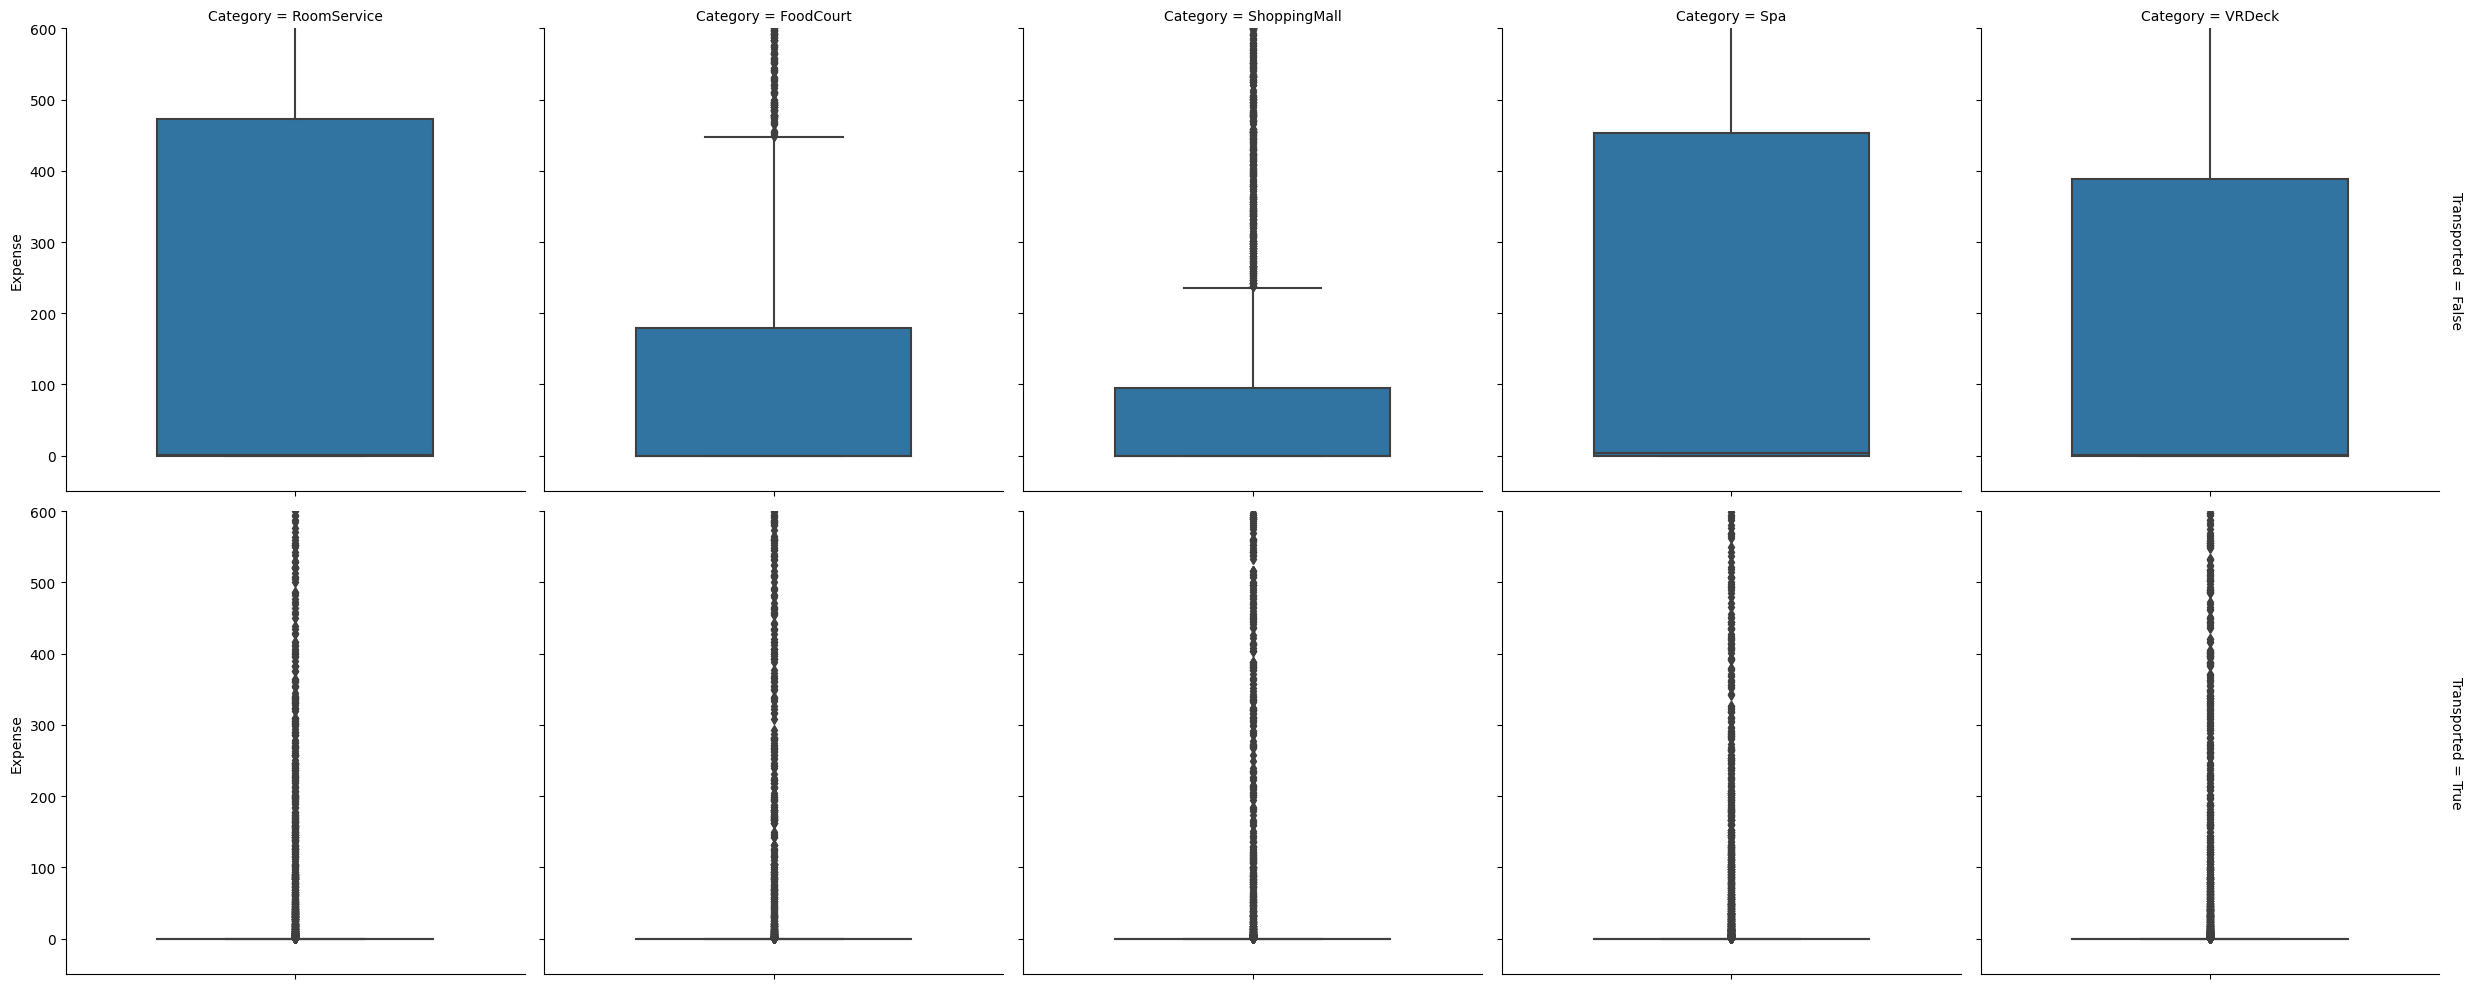

In [14]:
# Boxplot of Category vs Expense by Transported
g = sns.catplot(data=df_train_melt, col='Category', y='Expense', row='Transported', kind='box', margin_titles=True, 
                sharex=True, sharey=True, width=0.6)
g.set(ylim=(-50,600))

plt.show()

# Transported passengers appear to have **ZERO** expenses. 
* Create feature for Zero_Expenses (Total_Exp = 0)

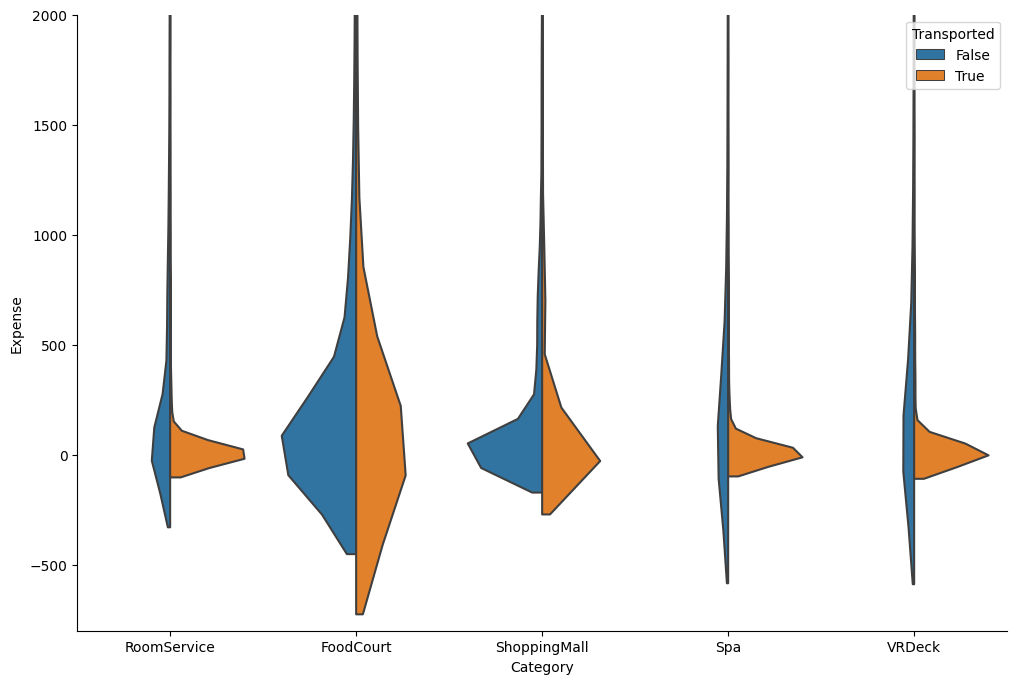

In [15]:
# Violinplot of Expense Categories by Transported
plt.figure(figsize=(12,8))
g = sns.violinplot(df_train_melt, x='Category',y='Expense',hue='Transported',split=True, inner=None)
g.set(ylim=(-800,2000))
sns.despine()
plt.show()

## RoomService, Spa, VRDeck appear to have similar shapes. FoodCourt and ShoppingMall also appear similar.

* Feature Engineering: 
    * Create group for RoomService, Spa, VRDeck named 'Luxury_Exp'
    * Create group for FoodCourt, ShoppingMall named 'Basic_Exp'

---
# Categorical Data Visualization: HomePlanet, CryoSleep, Destination, VIP

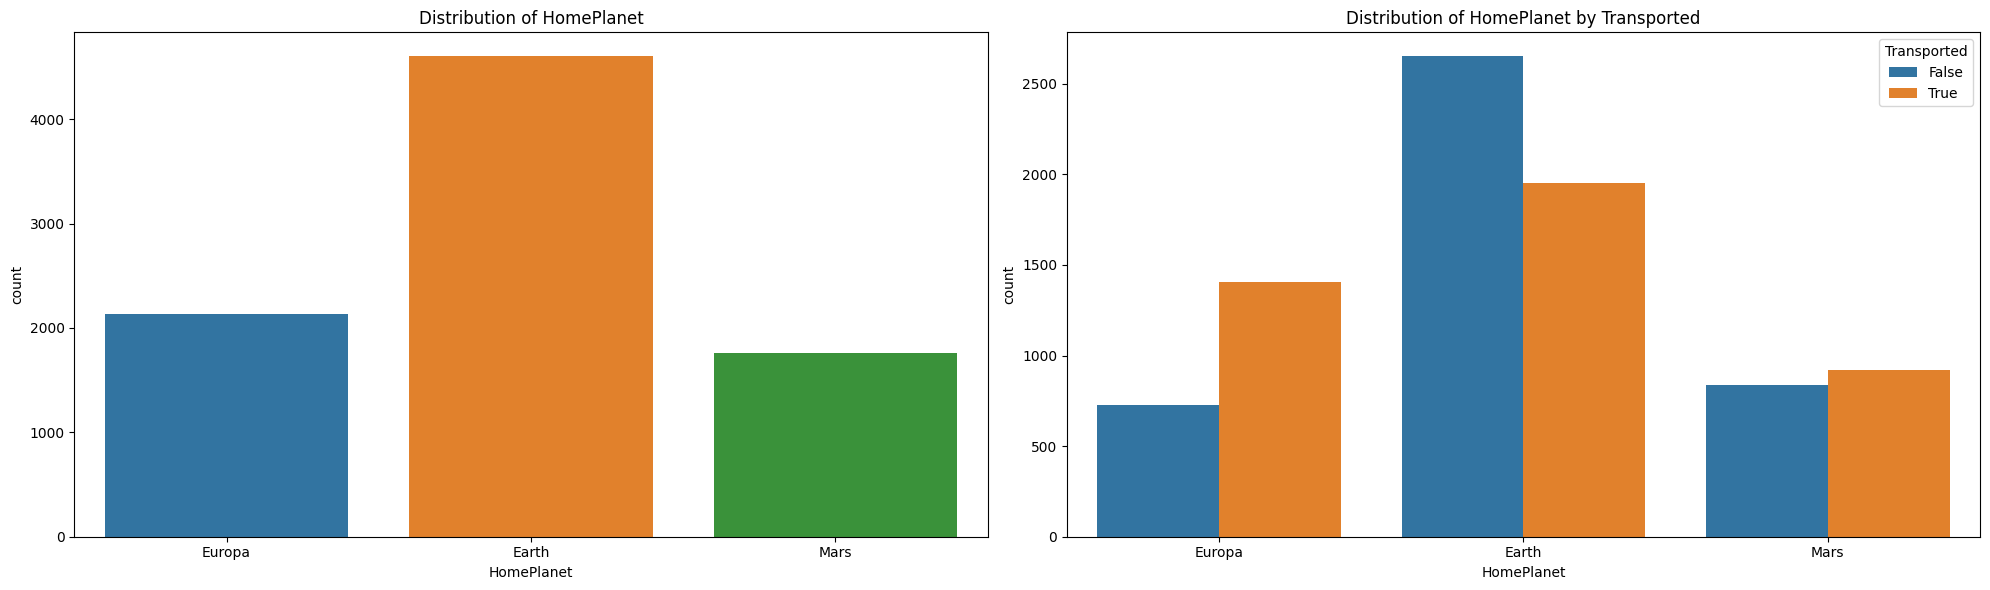

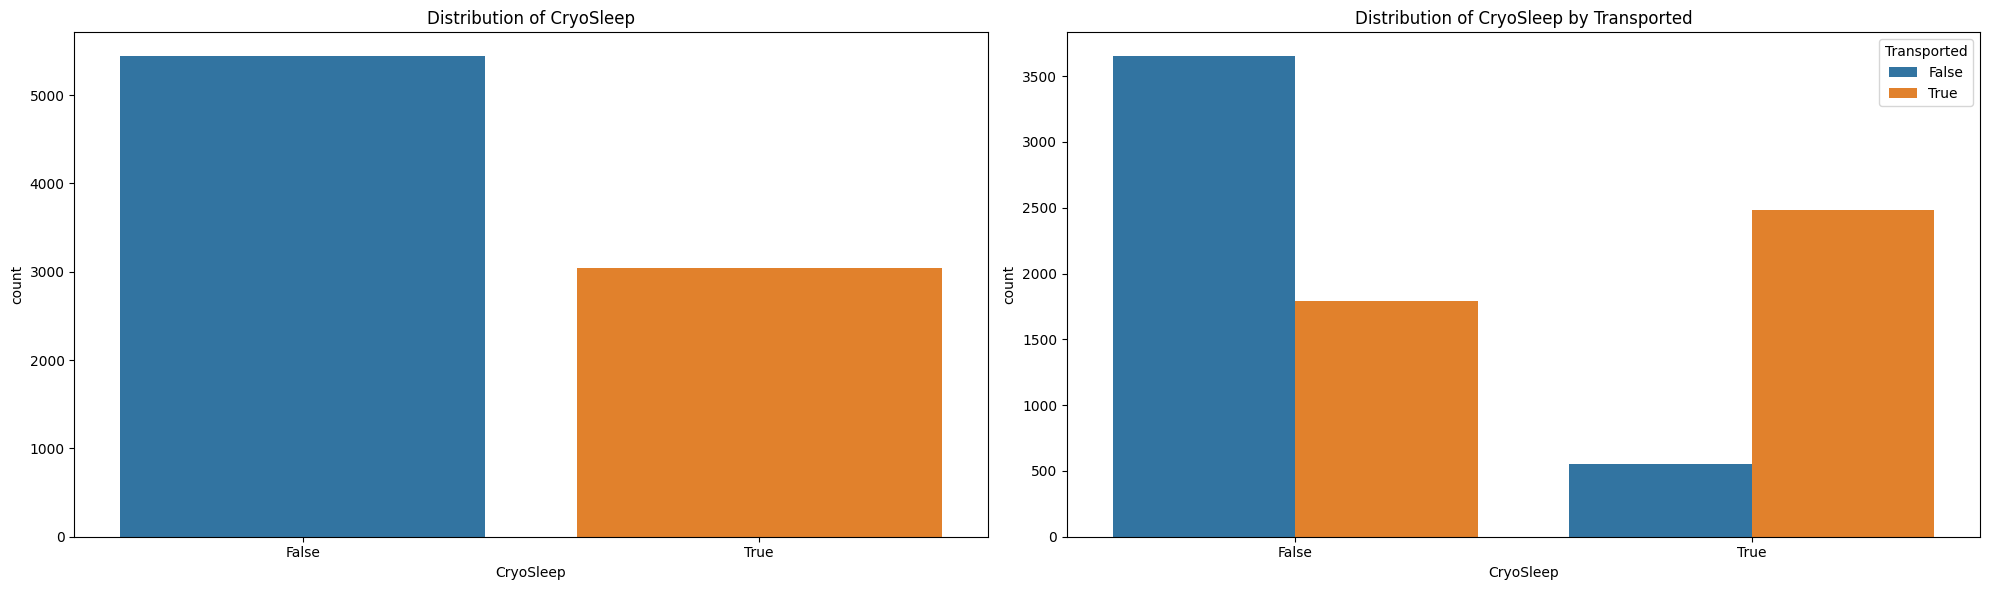

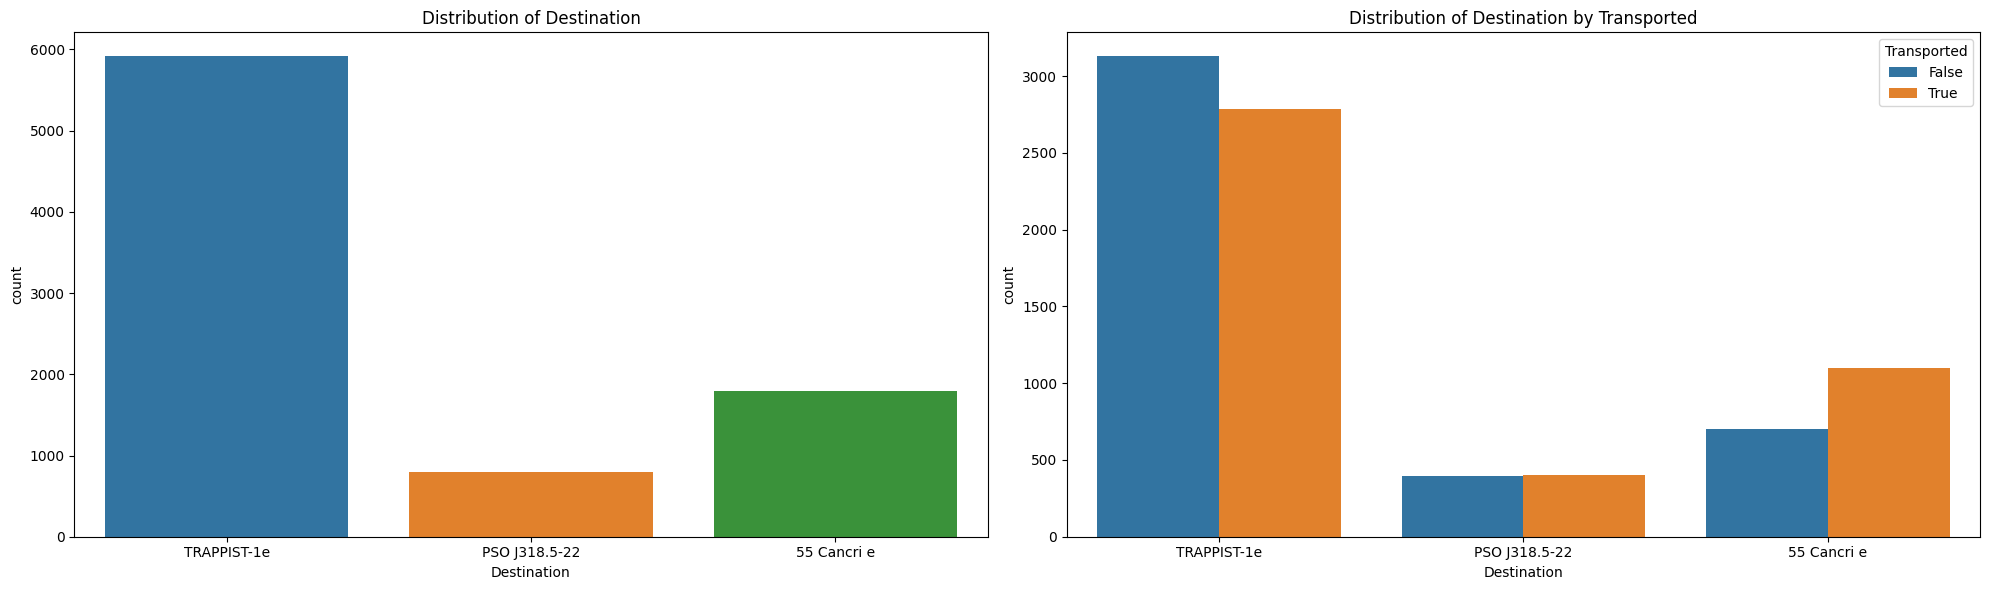

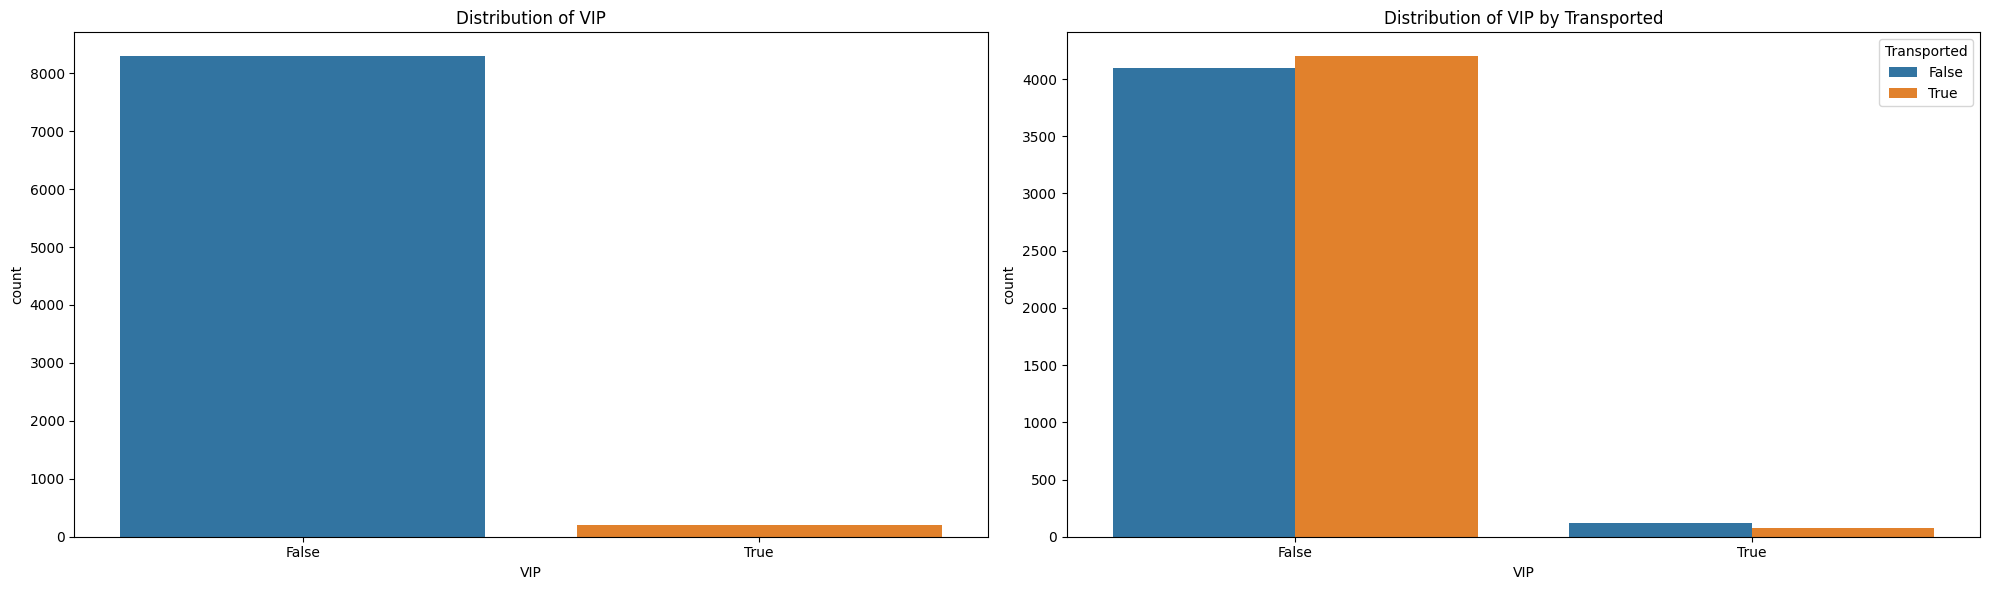

In [16]:
# Plot categorical features 

for col in ['HomePlanet', 'CryoSleep','Destination','VIP']:
    
    # Create figure for 2 subplots 
    fig, axs = plt.subplots(1,2, figsize=(20,6))

    # Distribution of column
    sns.countplot(df_train, x=col, ax=axs[0])
    axs[0].set_title(f'Distribution of {col}')

    # Distribution of column by Transported
    sns.countplot(df_train, x=col, hue='Transported', ax=axs[1])
    axs[1].set_title(f'Distribution of {col} by Transported')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

* Passengers from Europa and Mars more likely to be transported than from Earth.

* Passengers in CryoSleep more likely to be transported.

---
## Graphs for PassengerId, Cabin, and Name show high cardinality. Will implement feature engineering to extract relevant information.

* PassengerId: Split into Group_Num and Group_Ind_Num

* Cabin: Split into Cabin_Deck, Cabin_Number, Cabin_Side

* Name: Split into First Name and Last Name

---
# New Features

In [17]:
# Concatenate dataframes essentially stacking df_train and df_test
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

# Split PassengerId into Group_Num, Group_Ind_Num
df[['Group_Num','Group_Ind_Num']] = df['PassengerId'].str.split('_',expand=True)
df[['Group_Num','Group_Ind_Num']] = df[['Group_Num','Group_Ind_Num']].astype('int')

# Create Group_Size feature
df = df.merge(df.groupby('Group_Num').size().reset_index(name='Group_Size'),how='left',on='Group_Num')
df['Group_Num'] = df['Group_Num'].astype('int')

# Create IsAlone feature
df['Alone'] = df['Group_Size'].apply(lambda x: "Not Alone" if x>1 else "Alone")

# Split Cabin into Cabin_Deck, Cabin_Number, Cabin_Side
df[['Cabin_Deck','Cabin_Num','Cabin_Side']] = df['Cabin'].str.split('/',expand=True)
df['Cabin_Num'] = df['Cabin_Num'].astype(float)
df[['Cabin_Deck','Cabin_Side']] = df[['Cabin_Deck', 'Cabin_Side']].astype('category')

# Split Name into First Name and Last Name
df[['First_Name','Last_Name']] = df['Name'].str.split(' ',expand=True)

# # Create Total_Exp column
df['Total_Exp'] = df[['RoomService','FoodCourt','ShoppingMall','VRDeck','Spa']].sum(axis=1)

# Create Zero_Exp feature
df['Zero_Exp'] = (df['Total_Exp']==0).apply(lambda x: True if x==0 else False)

# Create Basic_Exp and Luxury_Exp features
df['Basic_Exp'] = df[['FoodCourt','ShoppingMall']].sum(axis=1)
df['Luxury_Exp'] = df[['RoomService','VRDeck','Spa']].sum(axis=1)

# Define cabin_num_region parameters
cabin_num_region_bins = [0,400,800,1200,1600,2000]
cabin_num_region_labels = ['1','2','3','4','5']

# Create Cabin_Num_Region feature
df['Cabin_Num_Region'] = pd.cut(
    df['Cabin_Num'],
    bins=cabin_num_region_bins,
    labels = cabin_num_region_labels,
    right=False, include_lowest=True)

# Define age_range parameters
age_range_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
age_range_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-80']

# Create Age_Range feature
df['Age_Range'] = pd.cut(
    df['Age'], 
    bins = age_range_bins,
    labels = age_range_labels, 
    right=False, include_lowest=True)

# Resplit data to avoid data leakage

In [18]:
# Split data back into df_train_updated and df_test_updated
df_train_updated = df[df['PassengerId'].isin(df_train['PassengerId'].values)].copy()
df_test_updated = df[df['PassengerId'].isin(df_test['PassengerId'].values)].copy()

# Finish adding new features

In [19]:
# Create Num_Relatives feature (done after split to avoid data leakage)
df_train_updated = df_train_updated.merge(df_train_updated.groupby('Last_Name').size().reset_index(name='Num_Relatives'), how='left', on='Last_Name')
df_test_updated = df_test_updated.merge(df_test_updated.groupby('Last_Name').size().reset_index(name='Num_Relatives'), how='left', on='Last_Name')

# Define num_relatives_range parameters
num_relatives_range_bins = [0,3,5,7,19]
num_relatives_range_labels = ['0-3','4-5','6-7','8-18']

# Create Num_Relatives_Range
df_train_updated['Num_Relatives_Range'] = pd.cut(
                                    x=df_train_updated['Num_Relatives'],
                                    bins=num_relatives_range_bins, 
                                    labels=num_relatives_range_labels, 
                                    right=True, include_lowest=True)

df_test_updated['Num_Relatives_Range'] = pd.cut(
                                    x=df_test_updated['Num_Relatives'],
                                    bins=num_relatives_range_bins, 
                                    labels=num_relatives_range_labels, 
                                    right=True, include_lowest=True)

# New Feature Analysis

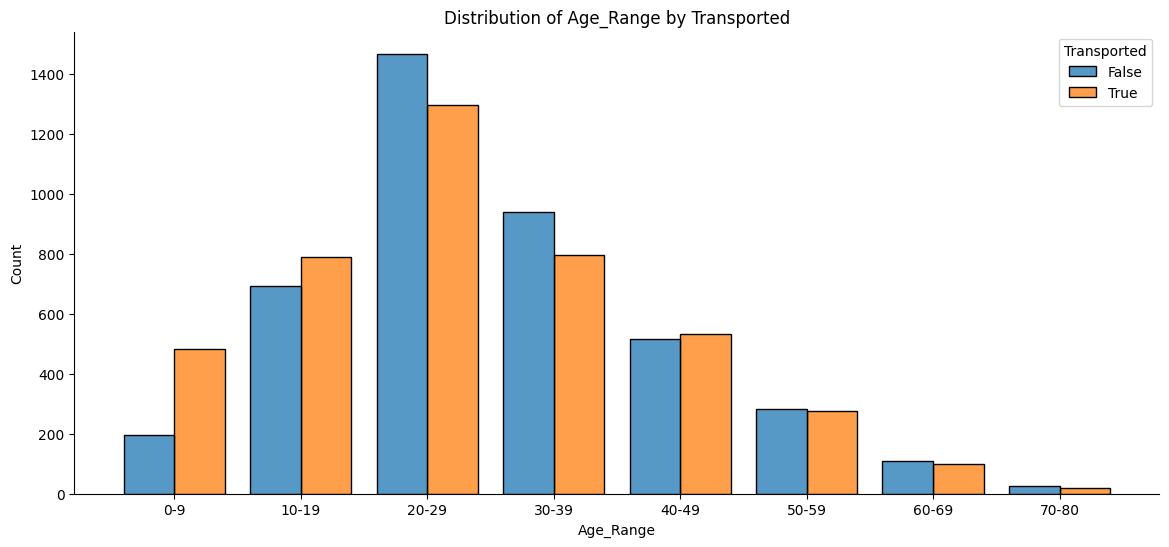

In [20]:
# Visualize distribution of Age_Range bins
plt.figure(figsize=(14,6))
sns.histplot(data=df_train_updated, x='Age_Range', hue='Transported', multiple='dodge', shrink=0.8)
plt.title('Distribution of Age_Range by Transported')
sns.despine()
plt.show()

# Total_Expense vs Transported

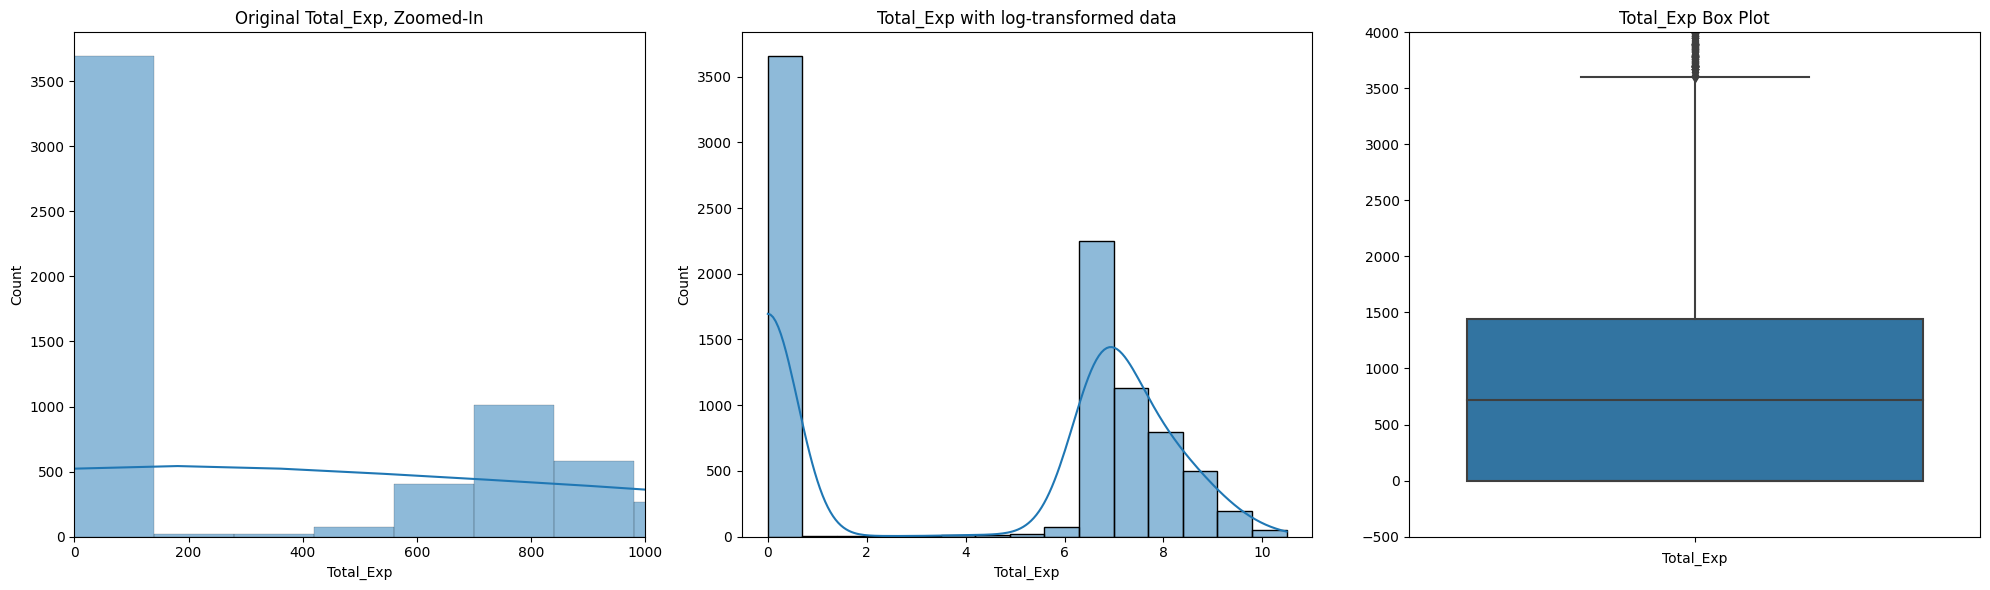

In [21]:
# Create figure for 3 subplots 
fig, axs = plt.subplots(1,3,figsize=(20,6))

# Original graph
sns.histplot(df_train_updated['Total_Exp'], kde=True, ax=axs[0])
axs[0].set_title('Original Total_Exp, Zoomed-In')
axs[0].set_xlim(0,1000)

# Log-transformed data
sns.histplot(np.log1p(df_train_updated['Total_Exp']), kde=True, ax=axs[1])
axs[1].set_title('Total_Exp with log-transformed data')

# Box Plot
sns.boxplot(df_train_updated['Total_Exp'], ax=axs[2])
axs[2].set_title('Total_Exp Box Plot')
axs[2].set_ylim(-500,4000)
axs[2].set_xlabel('Total_Exp')
axs[2].set_xticklabels([])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

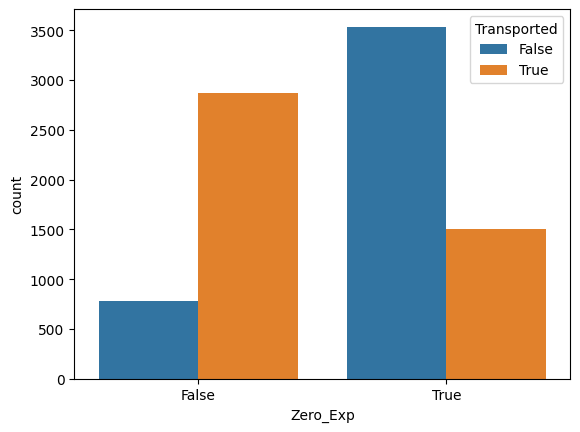

In [22]:
# Compare Zero_Exp by Transported
sns.countplot(df_train_updated, x='Zero_Exp', hue='Transported')
plt.show()

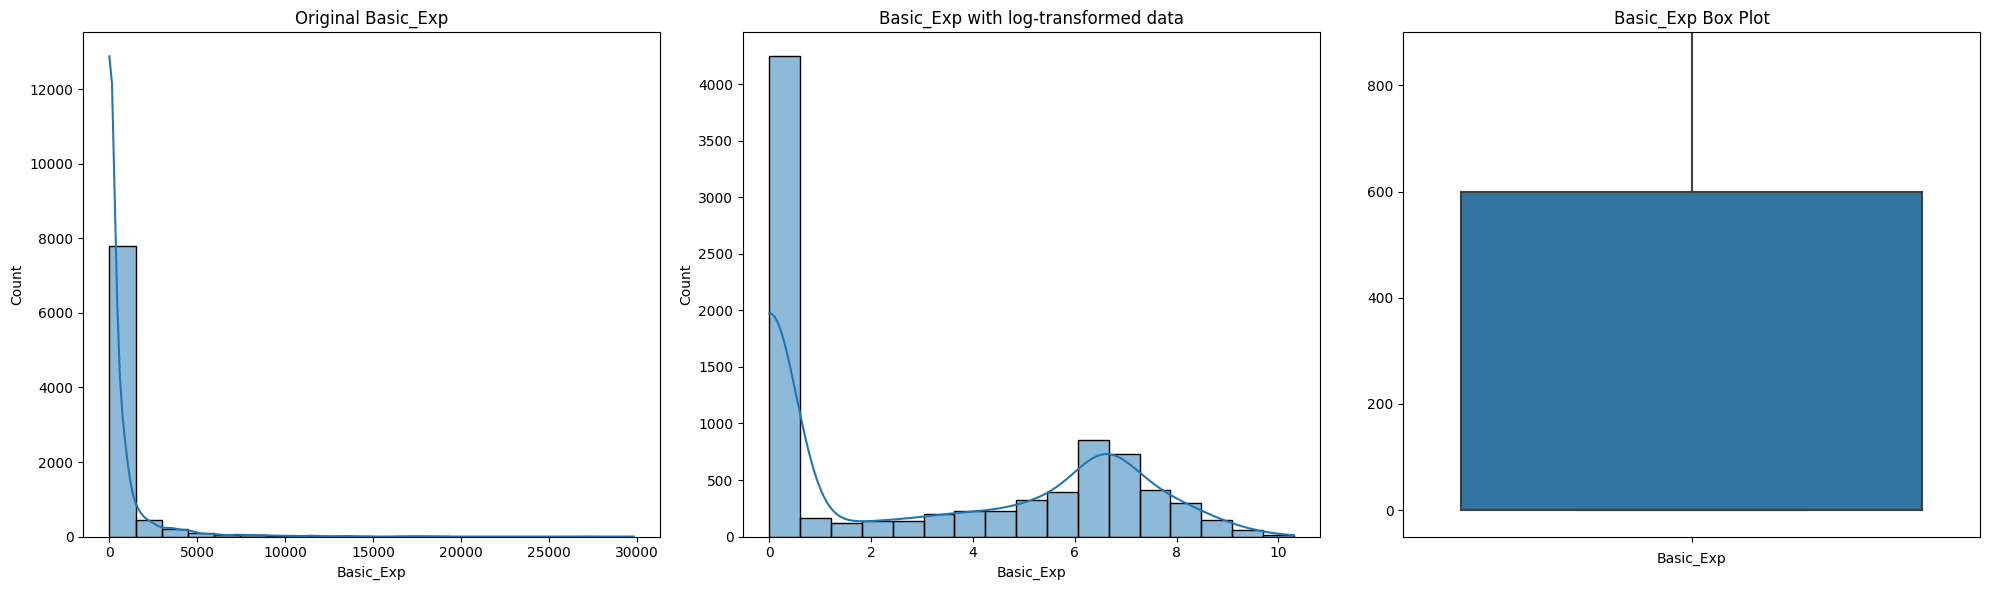

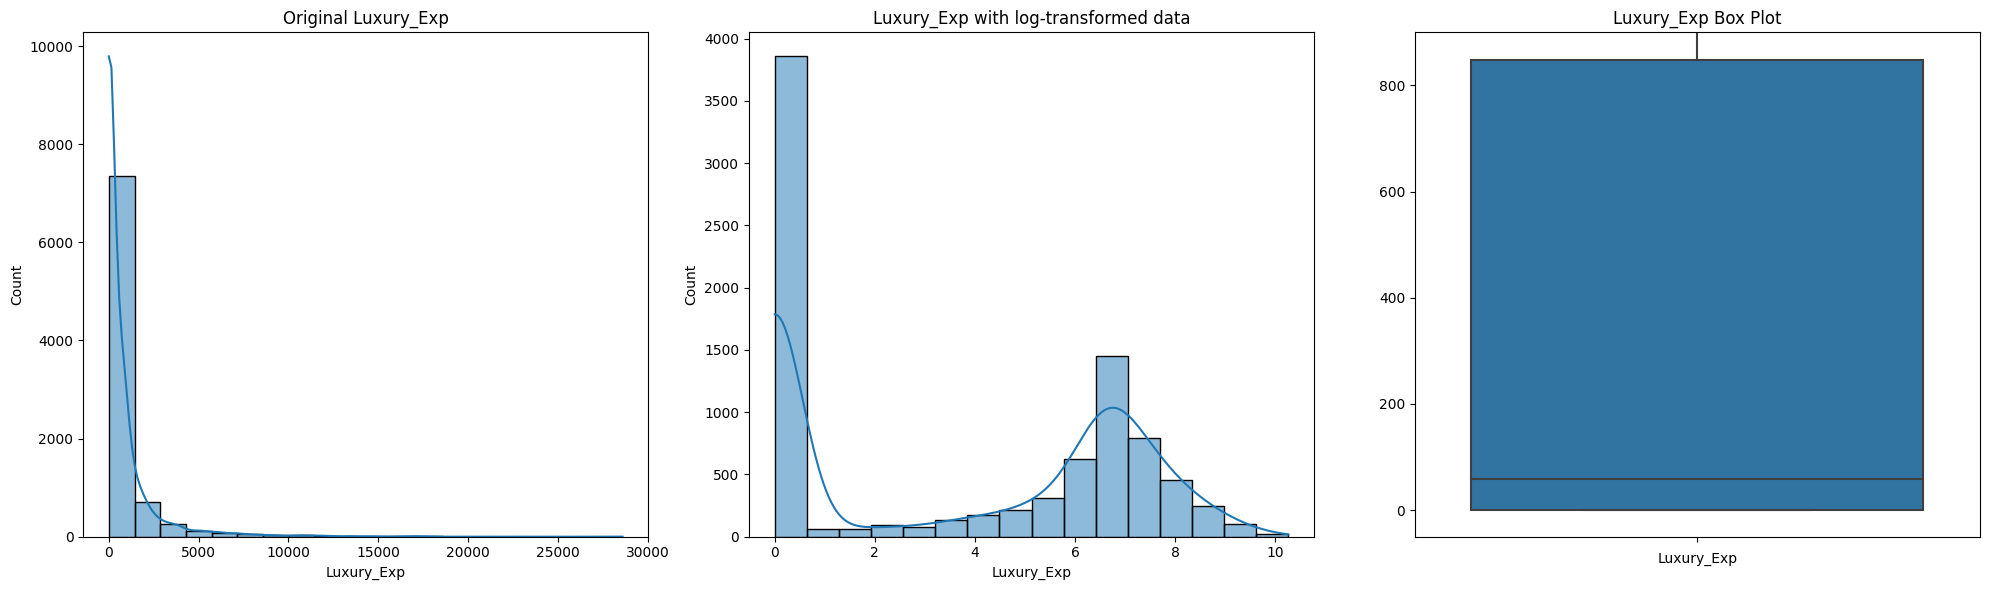

In [23]:
for col in ['Basic_Exp','Luxury_Exp']:
    # Create figure for 3 subplots 
    fig, axs = plt.subplots(1,3,figsize=(20,6))

    # Original graph
    sns.histplot(df_train_updated[col], kde=True, ax=axs[0], bins=20)
    axs[0].set_title(f'Original {col}')

    # Log-transformed data
    sns.histplot(np.log1p(df_train_updated[col]), kde=True, ax=axs[1])
    axs[1].set_title(f'{col} with log-transformed data')
    
    # Box Plot
    sns.boxplot(df_train_updated[col], ax=axs[2])
    axs[2].set_title(f'{col} Box Plot')
    axs[2].set_ylim(-50,900)
    axs[2].set_xlabel(col)
    axs[2].set_xticklabels([])

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

# Explore relationship between Luxury_Exp and Basic_Exp

In [24]:
df_expense_melt = pd.melt(df_train_updated, id_vars='Transported',value_vars=['Luxury_Exp','Basic_Exp'],var_name='Expense_Type',value_name='Expense_Value')
df_expense_melt

,Transported,Expense_Type,Expense_Value
0,False,Luxury_Exp,0.0
1,True,Luxury_Exp,702.0
2,False,Luxury_Exp,6807.0
3,False,Luxury_Exp,3522.0
4,True,Luxury_Exp,870.0
...,...,...,...
17381,False,Basic_Exp,6819.0
17382,False,Basic_Exp,0.0
17383,True,Basic_Exp,1872.0
17384,False,Basic_Exp,1049.0


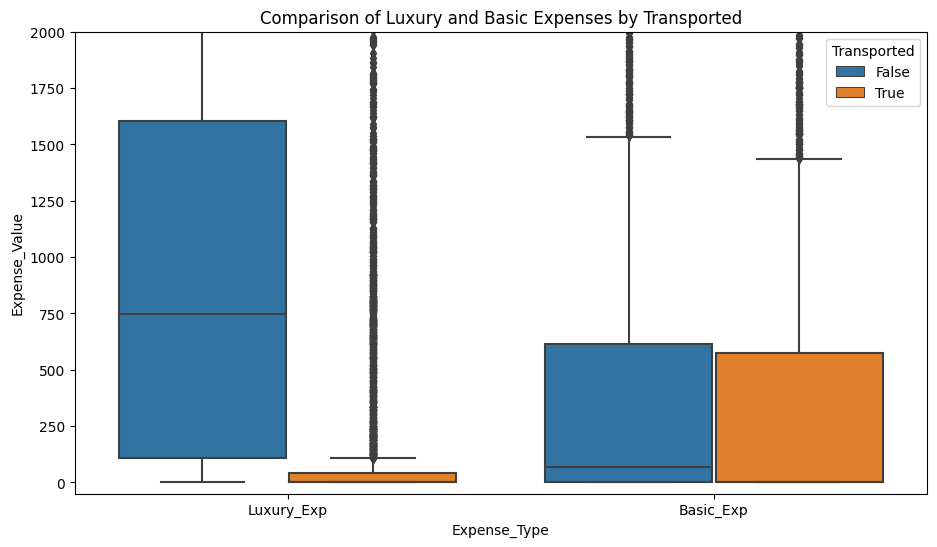

In [25]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

# Draw a boxplot with a narrower bandwidth than the default
sns.boxplot(data=df_expense_melt, x='Expense_Type', y='Expense_Value', hue='Transported')

# Finalize the figure
ax.set(ylim=(-50,2000))
plt.title('Comparison of Luxury and Basic Expenses by Transported')
plt.show()

In [26]:
# Visualize Age_Range by Expense columns
df_agerange_expense_melt = pd.melt(df_train_updated, id_vars=['Age_Range','Transported'], value_vars=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],var_name='Category',value_name='Expense')
df_agerange_expense_melt

,Age_Range,Transported,Category,Expense
0,30-39,False,RoomService,0.0
1,20-29,True,RoomService,109.0
2,50-59,False,RoomService,43.0
3,30-39,False,RoomService,0.0
4,10-19,True,RoomService,303.0
...,...,...,...,...
43460,40-49,False,VRDeck,74.0
43461,10-19,False,VRDeck,0.0
43462,20-29,True,VRDeck,0.0
43463,30-39,False,VRDeck,3235.0


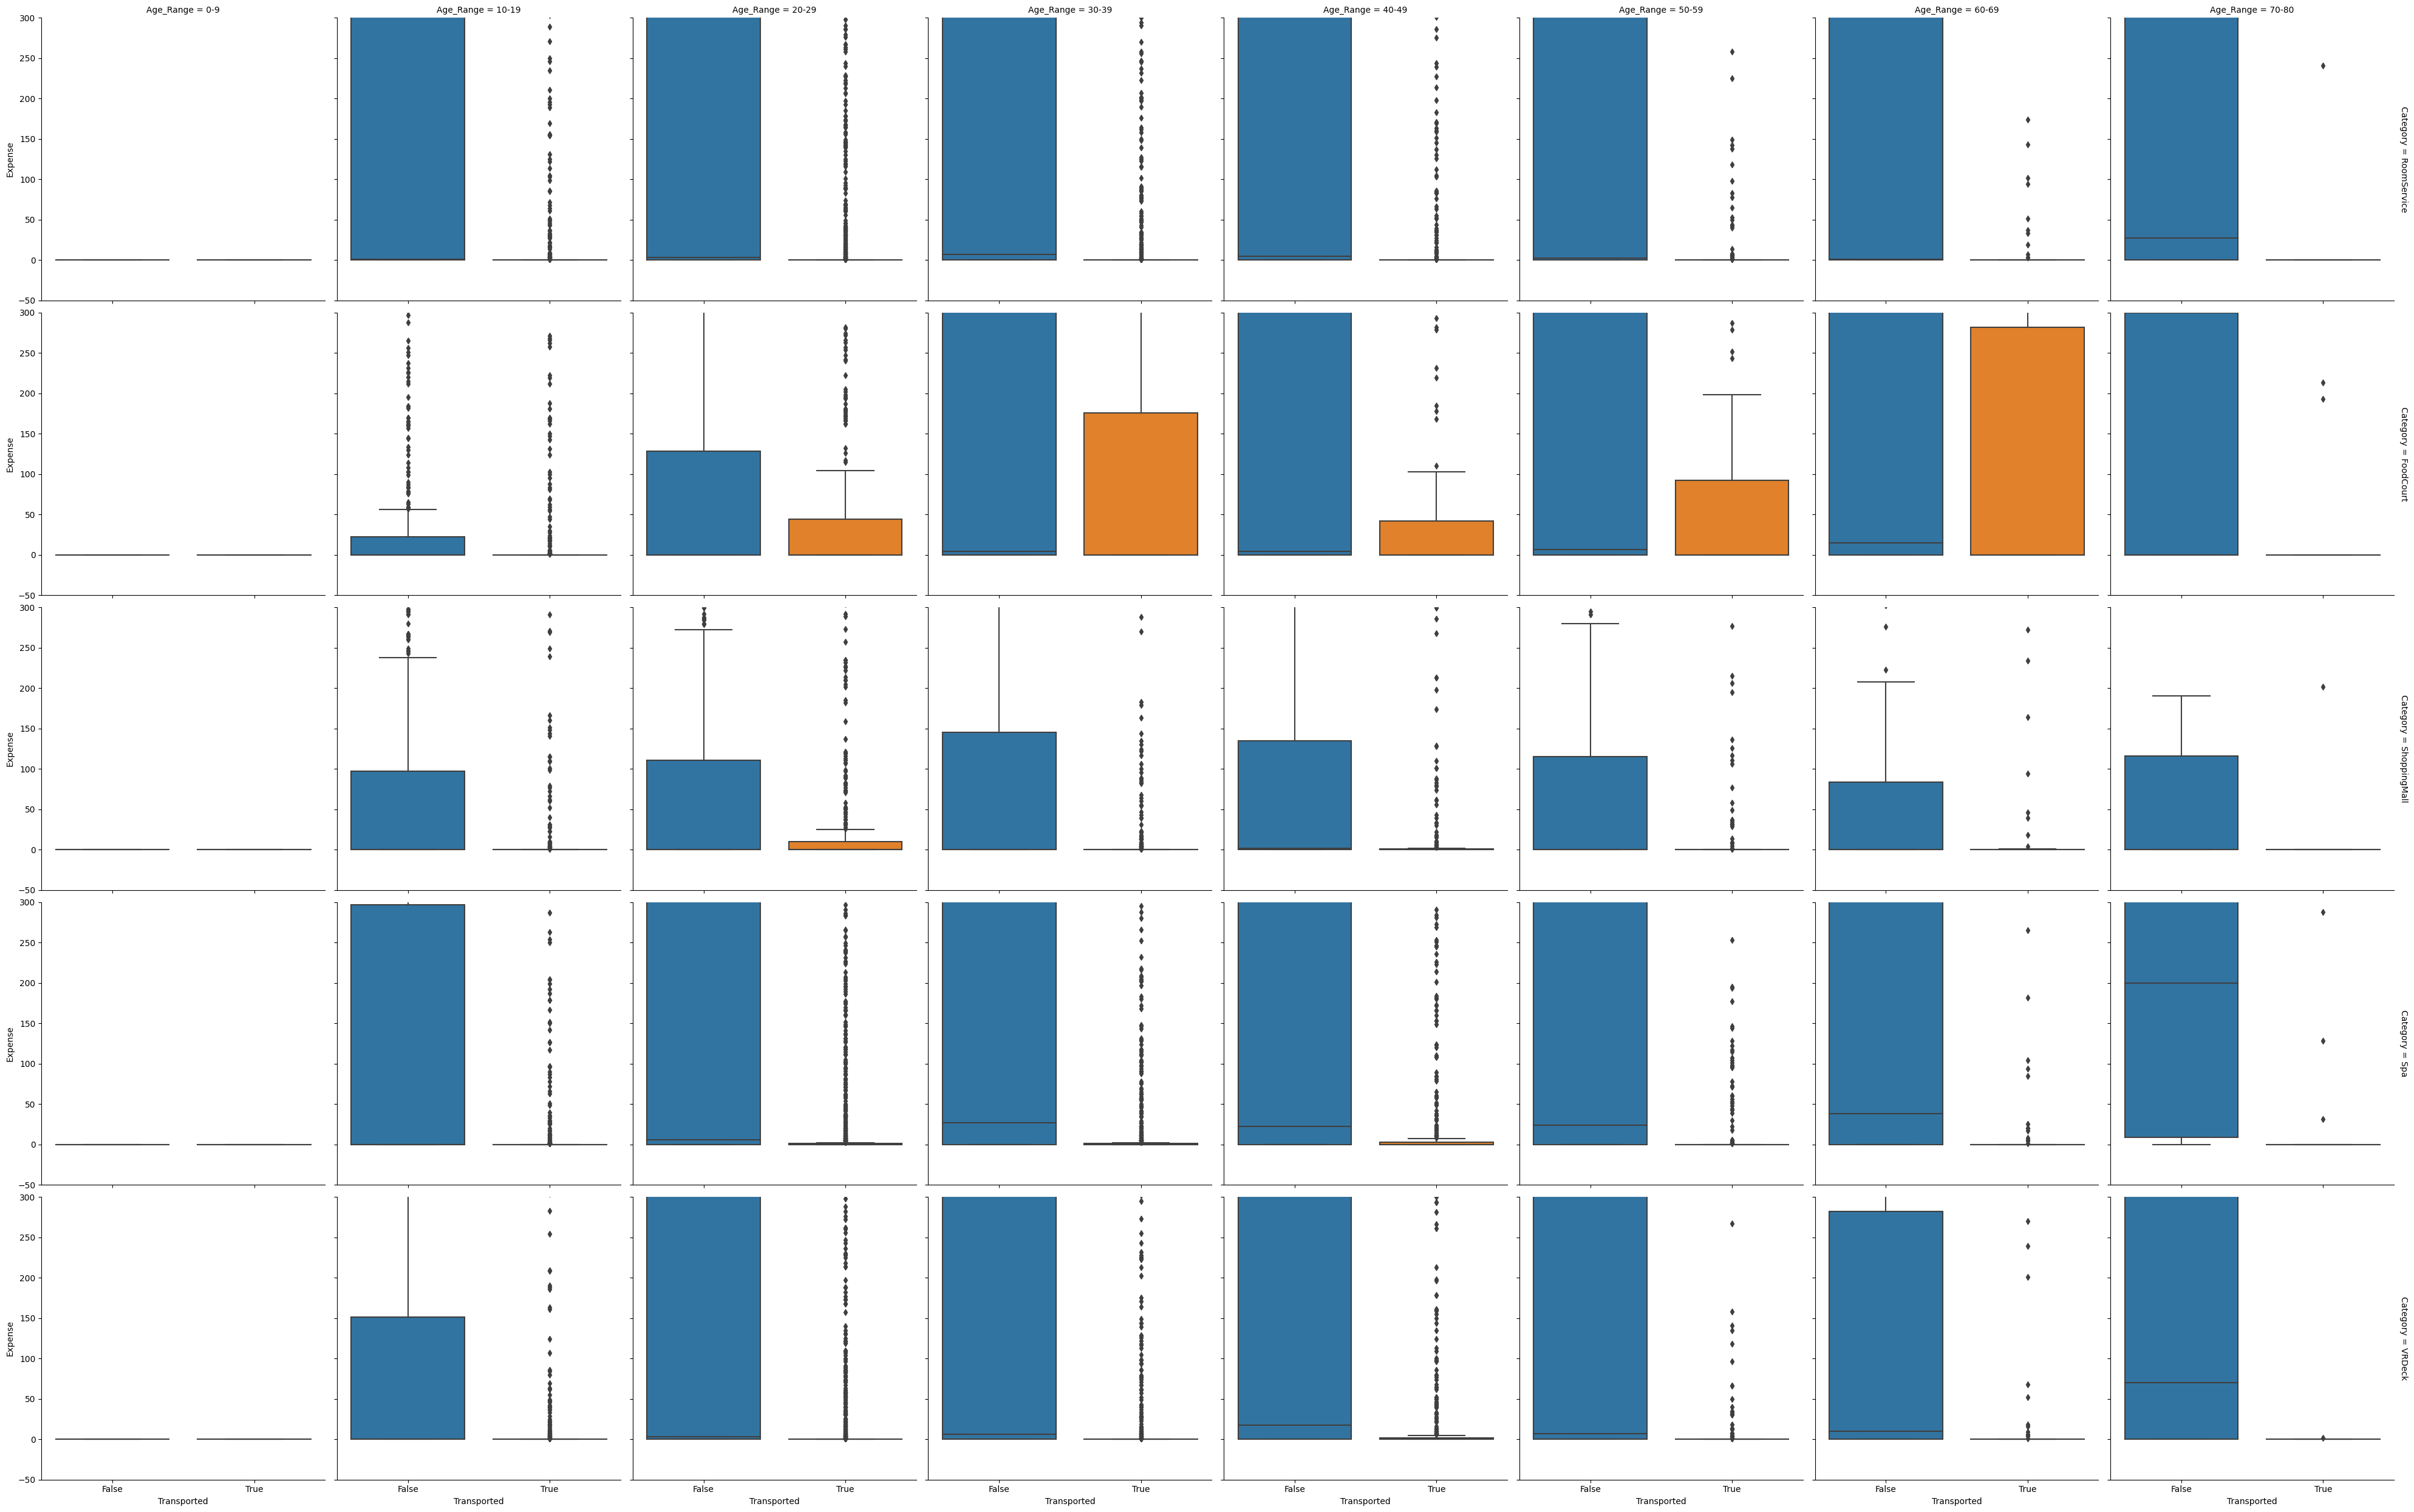

In [27]:
# Plot distributions of age_range and expense category by transported
g = sns.catplot(data=df_agerange_expense_melt, col='Age_Range', row='Category', kind='box', margin_titles=True, x='Transported', y='Expense')
g.set(ylim=(-50,300))

plt.show()

## Explore relationship between Group_Num and Group_Ind_Num by Transported

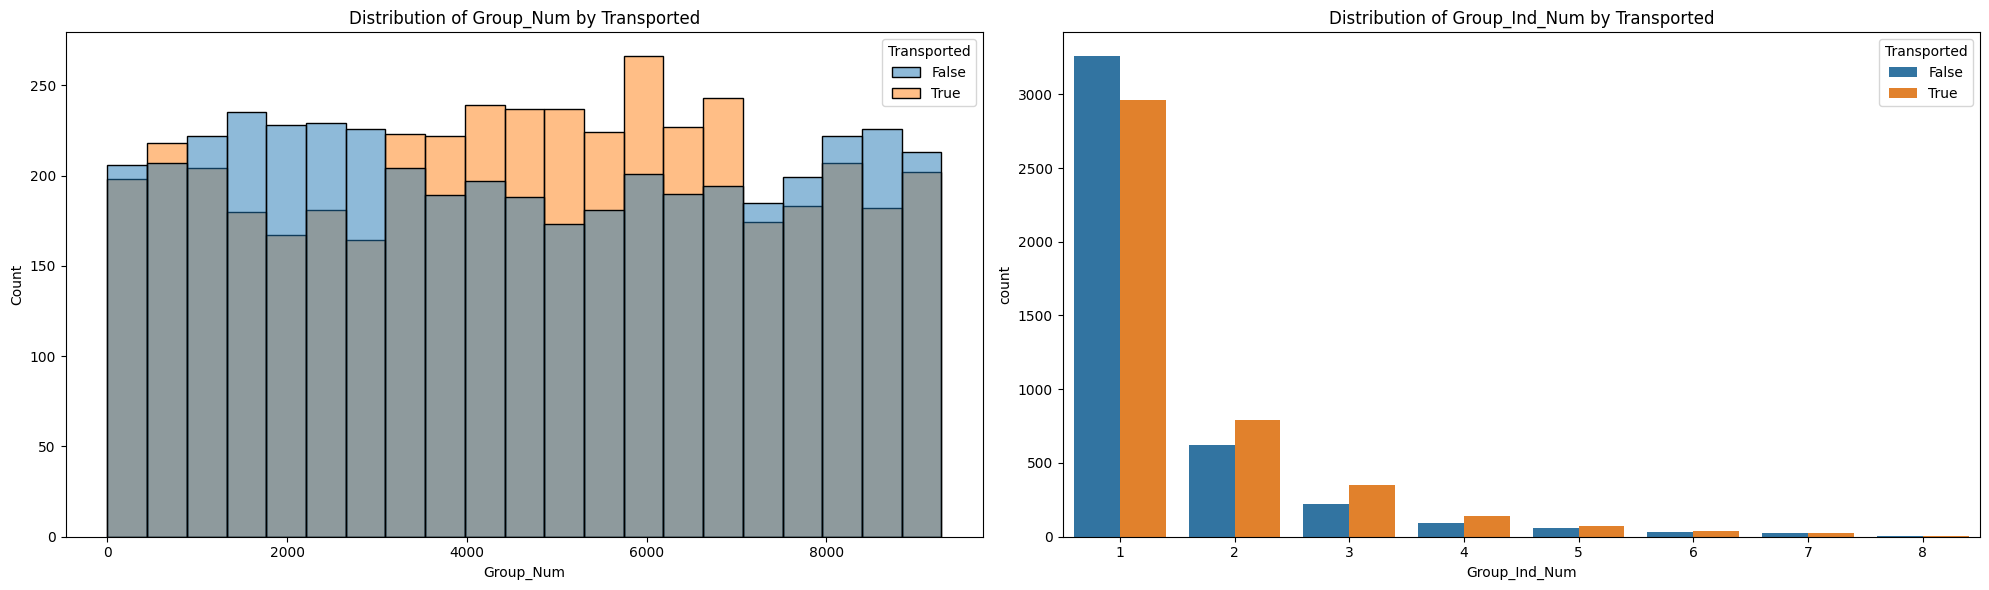

In [28]:
# Create figure for 2 subplots 
fig, axs = plt.subplots(1,2, figsize=(20,6))

# Distribution of Group_Num
sns.histplot(df_train_updated, x='Group_Num', hue='Transported', ax=axs[0])
axs[0].set_title('Distribution of Group_Num by Transported')

# Distribution of Group_Ind_Num
sns.countplot(df_train_updated, x='Group_Ind_Num', hue='Transported', ax=axs[1])
axs[1].set_title('Distribution of Group_Ind_Num by Transported')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

* **Group_Num has high cardinality and will likely not be useful in predicting target.**
* **Group_Ind_Num shows an interesting feature. Passengers assigned to Group_Ind_Num=1 are less likely to be transported than Group_Ind_Num>1.**
    * **Create IsAlone feature to determine if solo travelers have greater chance of being Transported.**
* **Can create Group_Size feature by using size of Group_Num.**

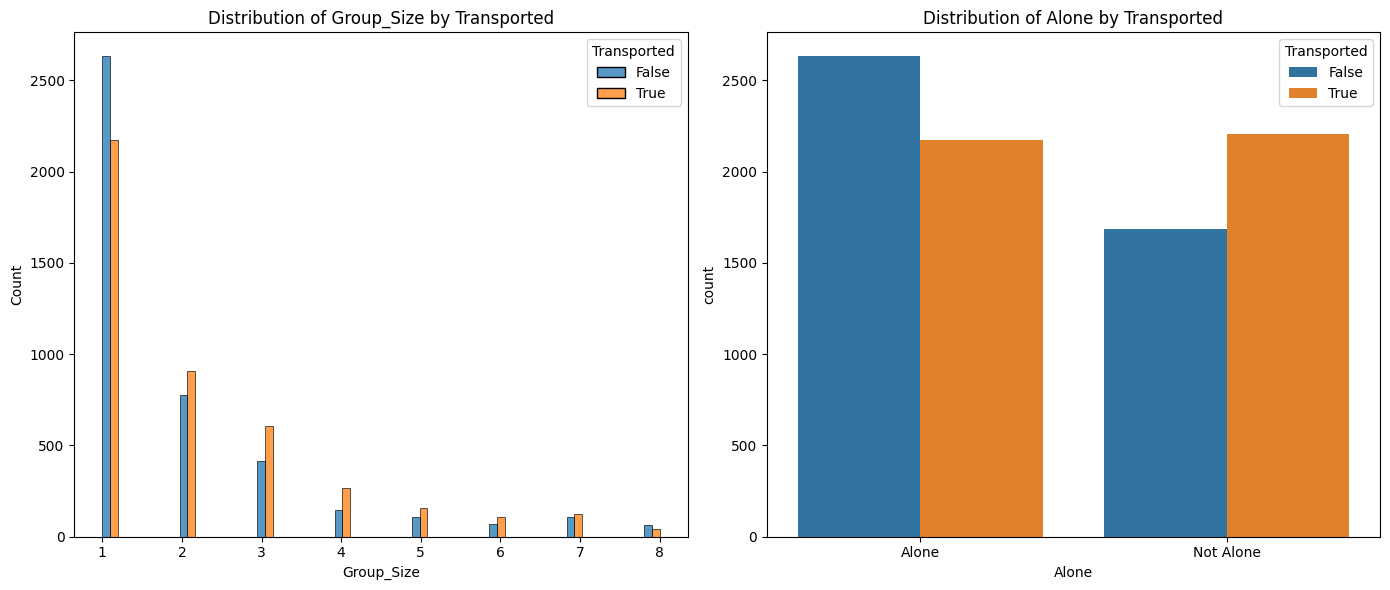

In [29]:
# Compare distributions of Group_Size and IsAlone features
fig, axs = plt.subplots(1,2, figsize=(14,6))

# Distribution of Group_Size by Transported
sns.histplot(data=df_train_updated, x='Group_Size', hue='Transported', multiple='dodge', ax=axs[0])
axs[0].set_title('Distribution of Group_Size by Transported')

# Distribution of IsAlone by Transported
sns.countplot(data=df_train_updated, x='Alone', hue='Transported', ax=axs[1])
axs[1].set_title('Distribution of Alone by Transported')

plt.tight_layout()
plt.show()

**Solo passengers less likely to be transported.**

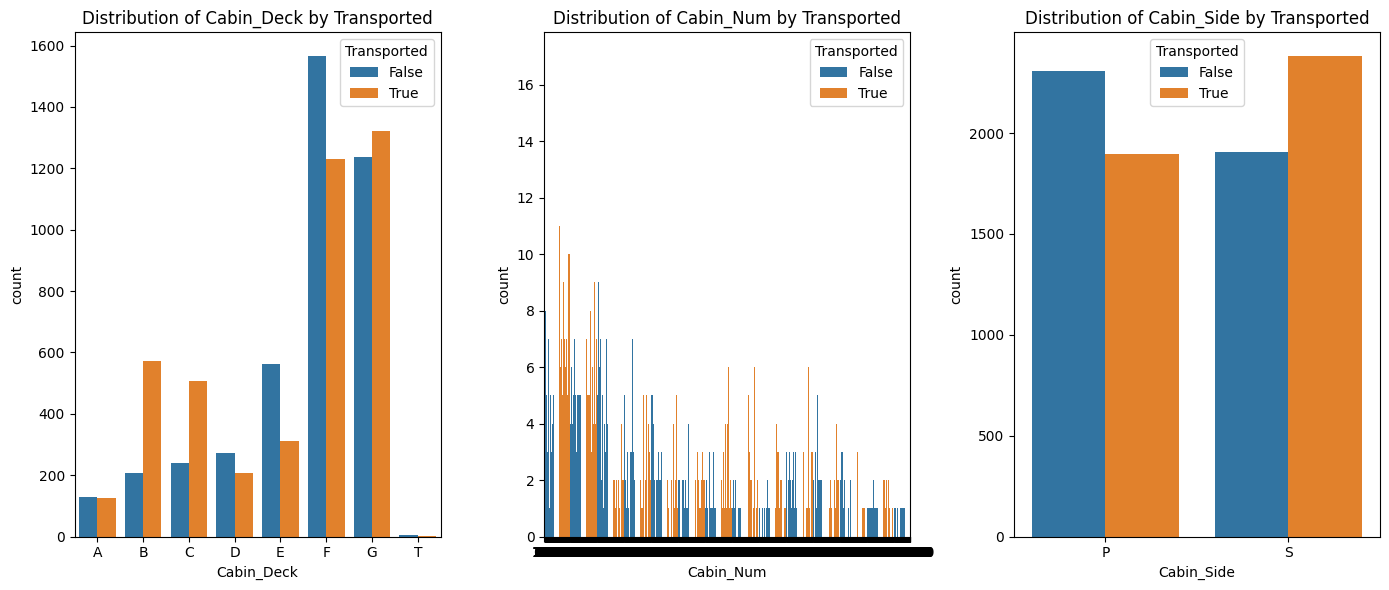

In [30]:
# Create subplots
fig, axs = plt.subplots(1,3,figsize=(14,6))

# Compare Distribution of Cabin_Deck by Transported
sns.countplot(data=df_train_updated, x='Cabin_Deck', hue='Transported', order=['A','B','C','D','E','F','G','T'], ax=axs[0])
axs[0].set_title('Distribution of Cabin_Deck by Transported')

# Compare Distribution of Cabin_Num by Transported
sns.countplot(data=df_train_updated, x='Cabin_Num',hue='Transported', ax=axs[1])
axs[1].set_title('Distribution of Cabin_Num by Transported')

# Compare Distribution of Cabin_Side by Transported
sns.countplot(data=df_train_updated, x='Cabin_Side',hue='Transported', ax=axs[2])
axs[2].set_title('Distribution of Cabin_Side by Transported')

# Show plot
plt.tight_layout()
plt.show()

* Passengers on Decks B, C, G significantly more likely to be transported. 
* Cabin_Num has high cardinality and likely to be dropped.
* Passengers on Starboard side more likely to be transported.

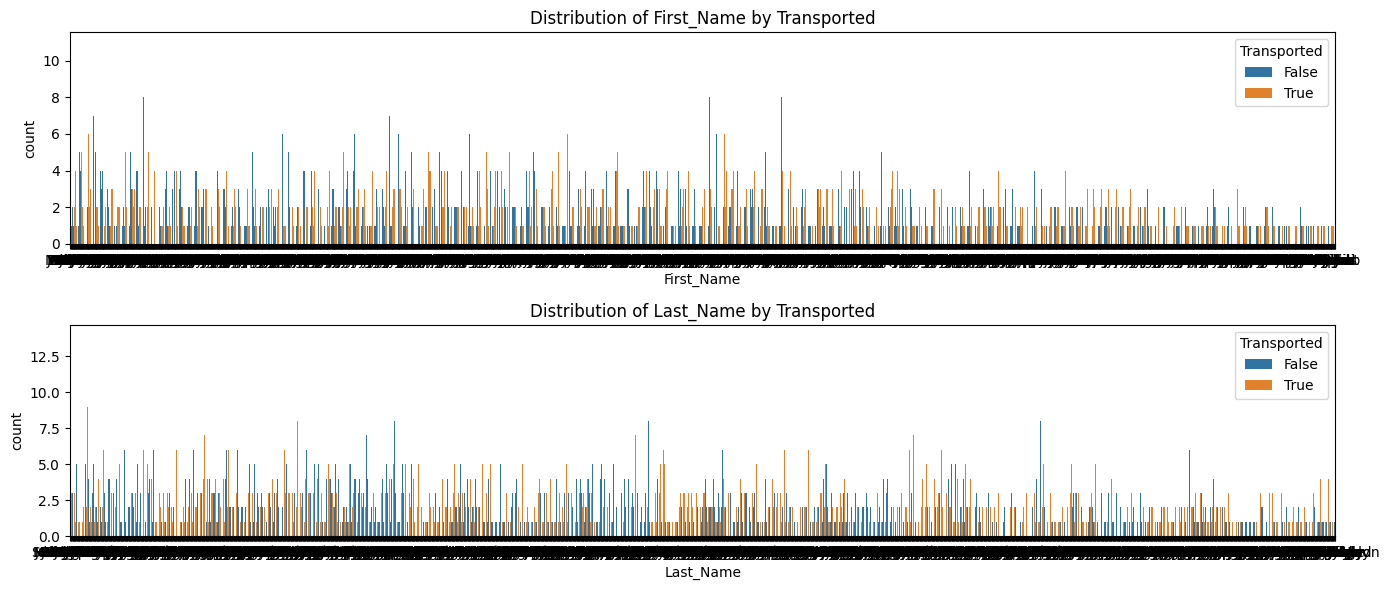

In [31]:
# Create subplots
fig, axs = plt.subplots(2,1,figsize=(14,6))

# Compare Distribution of First_Name by Transported
sns.countplot(data=df_train_updated, x='First_Name', hue='Transported', ax=axs[0])
axs[0].set_title('Distribution of First_Name by Transported')

# Compare Distribution of Cabin_Num by Transported
sns.countplot(data=df_train_updated, x='Last_Name',hue='Transported', ax=axs[1])
axs[1].set_title('Distribution of Last_Name by Transported')

# Show plot
plt.tight_layout()
plt.show()

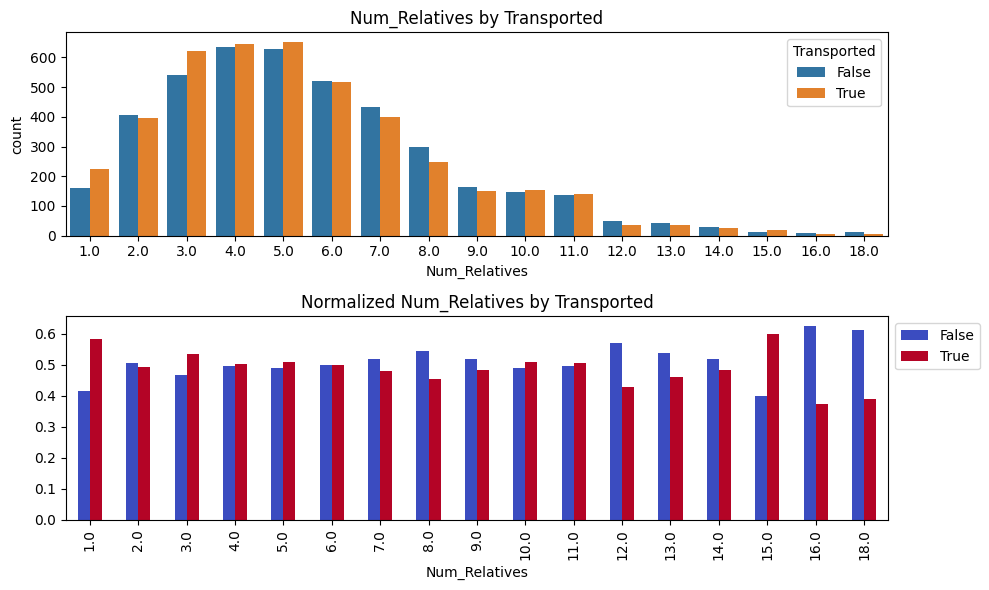

In [32]:
fig,axs = plt.subplots(2,1,figsize=(14,6))

# Plot Num_Relatives by Transported
sns.countplot(data=df_train_updated, x='Num_Relatives', hue='Transported', ax=axs[0])
axs[0].set_title('Num_Relatives by Transported')

# Plot Normalized Num_Relatives by Transported
ax = df_train_updated.groupby('Num_Relatives')['Transported'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=False, 
                                                                                                  figsize=(10, 6), colormap='coolwarm', 
                                                                                                  ax=axs[1])
ax.set_title('Normalized Num_Relatives by Transported')
ax.legend(bbox_to_anchor=(1, 1))

# Show Plot
plt.tight_layout()
plt.show()

* Passengers with 5 or less relatives tend to have better Transported values.
## Create Num_Relatives range

<Axes: xlabel='Num_Relatives_Range', ylabel='count'>

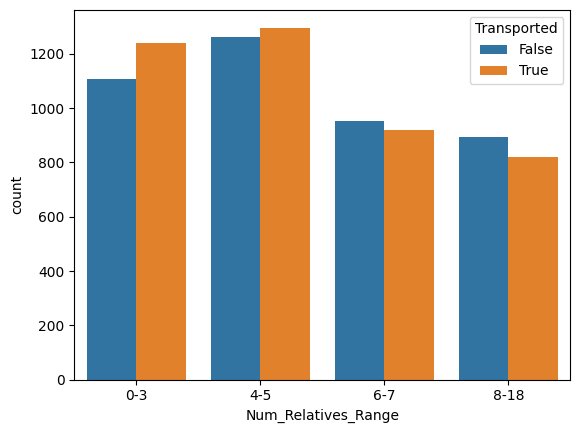

In [33]:
sns.countplot(data=df_train_updated, x='Num_Relatives_Range', hue='Transported')

# Target Data Visualization: Transported

In [34]:
Transported_vc = df_train_updated['Transported'].value_counts()
Transported_vc

Transported
True     4378
False    4315
Name: count, dtype: int64

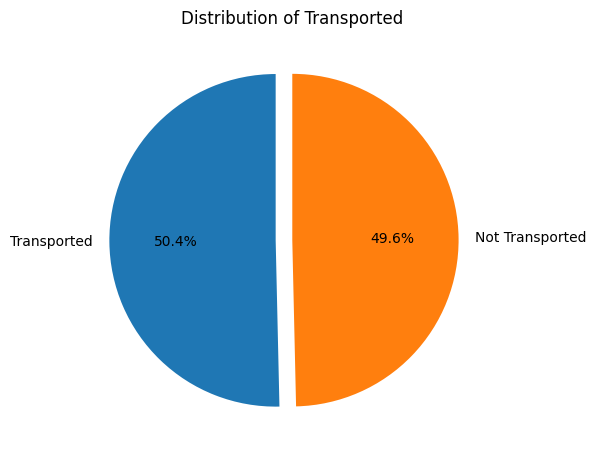

In [35]:
plt.figure(figsize=(6,6))
plt.pie(Transported_vc,labels=['Transported','Not Transported'],autopct='%1.1f%%',explode=[0.1,0], startangle=90)
plt.title('Distribution of Transported')
plt.tight_layout()
plt.show()

Target Variable indicates an **Even Distribution**.

---

# Missing Data

In [36]:
missing_data = df.isna().sum()
missing_data

PassengerId            0
HomePlanet           288
CryoSleep            310
Cabin                299
Destination          274
Age                  270
VIP                  296
RoomService          263
FoodCourt            289
ShoppingMall         306
Spa                  284
VRDeck               268
Name                 294
Transported         4277
Group_Num              0
Group_Ind_Num          0
Group_Size             0
Alone                  0
Cabin_Deck           299
Cabin_Num            299
Cabin_Side           299
First_Name           294
Last_Name            294
Total_Exp              0
Zero_Exp               0
Basic_Exp              0
Luxury_Exp             0
Cabin_Num_Region     299
Age_Range            270
dtype: int64

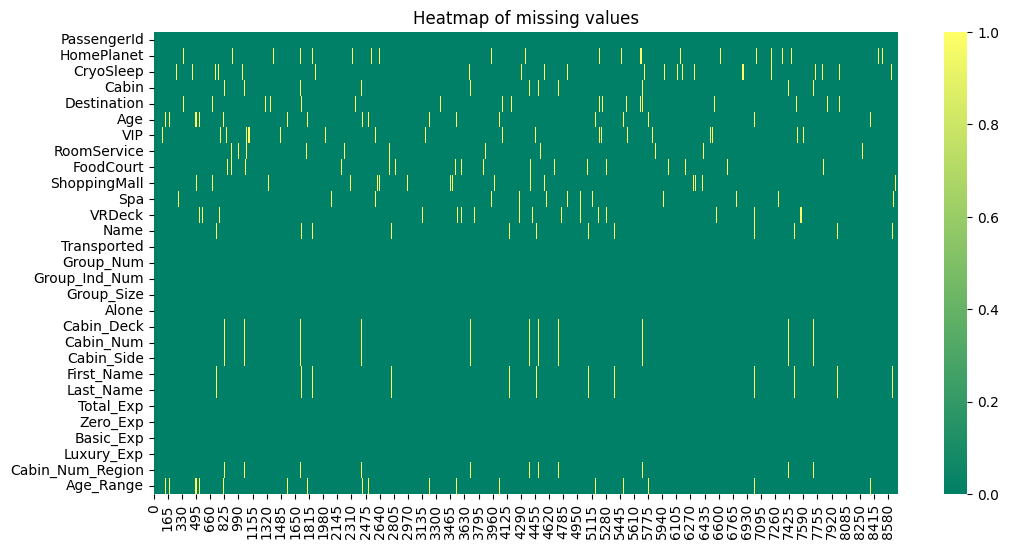

In [37]:
# Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(df_train_updated[missing_data.index].isna().T, cmap='summer')
plt.title('Heatmap of missing values')
plt.show()

* Missing data appears to be randomly distributed except for new features created on existing data, eg.:
    * Cabin
    * Name

In [38]:
# Boolean mask for identifying rows with NaN values
missing_data_row = df.isna().any(axis=1)
df[missing_data_row]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_Num,Group_Ind_Num,Group_Size,Alone,Cabin_Deck,Cabin_Num,Cabin_Side,First_Name,Last_Name,Total_Exp,Zero_Exp,Basic_Exp,Luxury_Exp,Cabin_Num_Region,Age_Range
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,6,2,2,Not Alone,G,0.0,S,Candra,Jacostaffey,0.0,False,0.0,0.0,1,20-29
10,0008_02,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True,8,2,3,Not Alone,B,1.0,P,Altardr,Flatic,0.0,False,0.0,0.0,1,30-39
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False,12,1,1,Alone,NaN,NaN,NaN,Justie,Pooles,908.0,True,876.0,32.0,NaN,30-39
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,Flats Eccle,False,14,1,1,Alone,F,3.0,P,Flats,Eccle,1408.0,True,122.0,1286.0,1,20-29
23,0020_03,Earth,True,E/0/S,55 Cancri e,29.0,False,0.0,0.0,NaN,0.0,0.0,Mollen Mcfaddennon,False,20,3,6,Not Alone,E,0.0,S,Mollen,Mcfaddennon,0.0,False,0.0,0.0,1,20-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,9266,2,2,Not Alone,G,1496.0,S,Jeron,Peter,0.0,False,0.0,0.0,4,30-39
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,9269,1,1,Alone,NaN,NaN,NaN,Matty,Scheron,1018.0,True,864.0,154.0,NaN,40-49
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,9271,1,1,Alone,D,296.0,P,Jayrin,Pore,0.0,False,0.0,0.0,1,NaN
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,9273,1,1,Alone,D,297.0,P,Kitakan,Conale,3203.0,True,2680.0,523.0,1,NaN


## The easiest way to deal with missing values is to just use the mean for numerical features and the mode for categorical features.

In [39]:
# Fill numerical columns with mean
for col in ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Num_Relatives']:
    df_train_updated[col] = df_train_updated[col].fillna(df_train_updated[col].mean())
    # Fill numerical columns in df_test_updated with mean from df_train_updated:
    df_test_updated[col] = df_test_updated[col].fillna(df_train_updated[col].mean())
    
# Fill categorical columns with mode
for col in ['HomePlanet', 'Destination', 'Cabin_Deck', 'Cabin_Num', 'Cabin_Side','CryoSleep','VIP']:
    df_train_updated[col] = df_train_updated[col].fillna(df_train_updated[col].mode()[0])
    # Fill missing categorical columns with mode from df_train_updated:
    df_test_updated[col] = df_test_updated[col].fillna(df_train_updated[col].mode()[0])

In [40]:
# List of columns that will be log transformed
log_transform_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total_Exp', 'Basic_Exp', 'Luxury_Exp']

df_train_updated[log_transform_cols] = np.log1p(df_train_updated[log_transform_cols])
df_test_updated[log_transform_cols] = np.log1p(df_test_updated[log_transform_cols])

In [41]:
# Update columns with new values
df_train_updated['Total_Exp'] = df_train_updated[['RoomService','FoodCourt','ShoppingMall','VRDeck','Spa']].sum(axis=1)
df_test_updated['Total_Exp'] = df_test_updated[['RoomService','FoodCourt','ShoppingMall','VRDeck','Spa']].sum(axis=1)

df_train_updated['Basic_Exp'] = df_train_updated[['FoodCourt','ShoppingMall']].sum(axis=1)
df_test_updated['Basic_Exp'] = df_test_updated[['FoodCourt','ShoppingMall']].sum(axis=1)

df_train_updated['Luxury_Exp'] = df_train_updated[['RoomService','VRDeck','Spa']].sum(axis=1)
df_test_updated['Luxury_Exp'] = df_test_updated[['RoomService','VRDeck','Spa']].sum(axis=1)

df_train_updated['Zero_Exp'] = df_train_updated['Total_Exp']==0
df_test_updated['Zero_Exp'] = df_test_updated['Total_Exp']==0

# After filling missing values with mean/mode, we can update existing range columns to "fill" values

In [42]:
# Update Age_Range
df_train_updated['Age_Range'] = pd.cut(
    df_train_updated['Age'], 
    bins = age_range_bins, 
    labels = age_range_labels, 
    right=False, include_lowest=True)

df_test_updated['Age_Range'] = pd.cut(
    df_test_updated['Age'], 
    bins = age_range_bins, 
    labels = age_range_labels, 
    right=False, include_lowest=True)

# Update Cabin_Num_Region
df_train_updated['Cabin_Num_Region'] = pd.cut(
    df_train_updated['Cabin_Num'],
    bins=cabin_num_region_bins,
    labels = cabin_num_region_labels,
    right=False, include_lowest=True)

df_test_updated['Cabin_Num_Region'] = pd.cut(
    df_test_updated['Cabin_Num'],
    bins=cabin_num_region_bins,
    labels = cabin_num_region_labels,
    right=False, include_lowest=True)

# Update Num_Relatives_Range
df_train_updated['Num_Relatives_Range'] = pd.cut(
    x=df_train_updated['Num_Relatives'],
    bins=num_relatives_range_bins, 
    labels=num_relatives_range_labels, 
    right=True, include_lowest=True)

df_test_updated['Num_Relatives_Range'] = pd.cut(
    x=df_test_updated['Num_Relatives'],
    bins=num_relatives_range_bins, 
    labels=num_relatives_range_labels,
    right=True, include_lowest=True)

In [43]:
# Drop unnecessary columns
drop_cols = ['Transported', 'PassengerId', 'Cabin', 'Name', 'First_Name', 'Last_Name']

df_train_updated = df_train_updated.drop(columns=drop_cols, axis=1)
df_test_updated = df_test_updated.drop(columns=drop_cols, axis=1)

In [44]:
# Confirm all missing values removed
print(df_train_updated.isna().sum())
print('-'*30)
print(df_test_updated.isna().sum())

HomePlanet             0
CryoSleep              0
Destination            0
Age                    0
VIP                    0
RoomService            0
FoodCourt              0
ShoppingMall           0
Spa                    0
VRDeck                 0
Group_Num              0
Group_Ind_Num          0
Group_Size             0
Alone                  0
Cabin_Deck             0
Cabin_Num              0
Cabin_Side             0
Total_Exp              0
Zero_Exp               0
Basic_Exp              0
Luxury_Exp             0
Cabin_Num_Region       0
Age_Range              0
Num_Relatives          0
Num_Relatives_Range    0
dtype: int64
------------------------------
HomePlanet             0
CryoSleep              0
Destination            0
Age                    0
VIP                    0
RoomService            0
FoodCourt              0
ShoppingMall           0
Spa                    0
VRDeck                 0
Group_Num              0
Group_Ind_Num          0
Group_Size             0
Alone 

In [45]:
# Create features and labels
X = df_train_updated.copy()
y = df_train['Transported'].copy().astype(int).copy()
test = df_test_updated.copy()

In [46]:
X.shape, y.shape, test.shape

((8693, 25), (8693,), (4277, 25))

---

In [47]:
# List of columns to scale
numeric_cols = [
    'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Group_Num',  'Group_Size', 'Cabin_Num', 'Total_Exp', 
    'Basic_Exp', 'Luxury_Exp', 'Num_Relatives',  'Group_Ind_Num' 
]

# Scaler transformation pipeline for all numeric columns
numeric_preprocessor = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

# List of categorical columns to One Hot Encode
categorical_cols = [
    'HomePlanet', 'CryoSleep', 'Cabin_Side', 'Zero_Exp',  
    'Age_Range', 'Alone', 'Cabin_Deck', 'Cabin_Num_Region', 'Destination', 'Num_Relatives_Range','VIP'
]

# Categorical column transformer
categorical_preprocessor = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore",drop='if_binary'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numeric_cols),
        ("cat", categorical_preprocessor, categorical_cols)
    ],
    remainder='passthrough'
)

In [48]:
# Logistic regression Pipeline
lr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(random_state=42))]
)

# Random Forest pipeline
rf_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(random_state=42))]
)

# K-Nearest Neighbors pipeline
knn_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", KNeighborsClassifier())]
)

# Support Vector Classifier pipeline
svc_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", SVC(random_state=42, probability=True))]
)

# Decision Tree pipeline
dt_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", DecisionTreeClassifier(random_state=42))]
)

# XGBoost pipeline
# xgb_pipe = Pipeline(
#     steps=[
#         ("preprocessor", preprocessor),
#         ("model", XGBClassifier(random_state=42))])

In [49]:
# Logistic regression parameter grid
lr_param_grid = {
    'model__penalty': ['l1','l2'],
    'model__C': [0.01, 0.1, 0.5, 0.75, 1],
    'model__max_iter': [50, 100, 150]
}

# Random Forest parameter grid 
rf_param_grid = {
    'model__n_estimators': [50,100,150,200,250,300],
    'model__max_depth': [4,6,8,10,12]}

# KNN_grid
knn_param_grid = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__p': [1, 2]}

# Support Vector Classifier parameter grid
svc_param_grid = {
    'model__C': [1, 1.25, 1.5],
    'model__kernel': ['rbf'],
    'model__gamma': ['scale']}

# Decision Tree parameter grid
dt_param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__min_samples_leaf': [1,2,3,4,5,6],
    'model__max_depth': [1,2,3,4,5,6],
    'model__min_samples_split': [2,3,4,5,6]}

# XGBoost parameter grid
# xgb_param_grid = {
#     'model__learning_rate': [0.1, 0.2, 0.3],
#     'model__max_depth': [1,2,3,4,5,6],
#     'model__min_child_weight': [1,2],
#     'model__Xubsample': [1, 0.5, 0.1],
#     'model__n_estimators': [50, 100, 150]}

In [50]:
# Create GridSearchCV objects
lr_grid_search = GridSearchCV(
    estimator=lr_pipe, 
    param_grid=lr_param_grid,
    scoring='accuracy',
    cv=3)

rf_grid_search = GridSearchCV(
    estimator=rf_pipe, 
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=3)

knn_grid_search = GridSearchCV(
    estimator=knn_pipe, 
    param_grid=knn_param_grid,
    scoring='accuracy',
    cv=3)

svc_grid_search = GridSearchCV(
    estimator=svc_pipe, 
    param_grid=svc_param_grid,
    scoring='accuracy',
    cv=3)

dt_grid_search = GridSearchCV(
    estimator=dt_pipe, 
    param_grid=dt_param_grid,
    scoring='accuracy',
    cv=3)

# xgb_grid_search = GridSearchCV(
#     estimator=xgb_pipe, 
#     param_grid=xgb_param_grid,
#     scoring='accuracy',
#     cv=3)

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
pipes = [
    lr_pipe,
    rf_pipe,
    knn_pipe,
    svc_pipe,
    dt_pipe,
#     xgb_pipe
]

grids = [
    lr_grid_search,
    rf_grid_search,
    knn_grid_search,
    svc_grid_search,
    dt_grid_search,
#     xgb_grid_search
]

In [53]:
grid_dict = {
    0: 'Logistic Regression',
    1: 'Random Forest', 
    2: 'K-Nearest Neighbors', 
    3: 'Support Vector Classifier',
    4: 'Decision Tree',
#     5: 'XGBoost'
}

In [54]:
pipe_results = []
for i, model in enumerate(pipes):
    # Track the time taken to fit the model
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    fit_time = end_time - start_time
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate various metrics
    train_score = model.score(X_train, y_train)
    val_score = accuracy_score(y_val, y_pred)
    pipe_results.append({
        'Model': grid_dict[i],
        'Training Score': train_score,
        'Validation Score': val_score,
        'Fit Time (s)': fit_time
    })

In [55]:
# Convert the results list into a DataFrame
pipe_results_df = pd.DataFrame(pipe_results).sort_values(by='Validation Score', ascending=False)
pipe_results_df

,Model,Training Score,Validation Score,Fit Time (s)
3,Support Vector Classifier,0.830457,0.794135,10.671923
1,Random Forest,1.000000,0.791834,1.596371
0,Logistic Regression,0.780846,0.776883,0.211116
2,K-Nearest Neighbors,0.840092,0.749281,0.050115
4,Decision Tree,1.000000,0.738355,0.153342


In [56]:
grid_results = []
for i, grid_search in enumerate(grids):
    # Track the time taken to fit the grid_search model
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    fit_time = end_time - start_time
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions
    y_pred = best_model.predict(X_val)
    
    # Calculate various metrics
    train_score = best_model.score(X_train, y_train)
    val_score = grid_search.best_score_  # This is cross-validated best score
    grid_results.append({
        'Model': grid_dict[i],
        'Best Parameters': best_params,
        'Training Score': train_score,
        'Best Validation Score': val_score,
        'Fit Time (s)': fit_time
    })

In [57]:
# Visualize full parameters
pd.set_option('display.max_colwidth', None)

# Convert the grid_results list into a DataFrame
grid_results_df = pd.DataFrame(grid_results).sort_values(by='Best Validation Score', ascending=False)
grid_results_df

,Model,Best Parameters,Training Score,Best Validation Score,Fit Time (s)
1,Random Forest,"{'model__max_depth': 10, 'model__n_estimators': 200}",0.874748,0.801265,125.528723
3,Support Vector Classifier,"{'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}",0.830457,0.795226,57.379984
4,Decision Tree,"{'model__criterion': 'gini', 'model__max_depth': 6, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}",0.813776,0.792637,88.656542
0,Logistic Regression,"{'model__C': 0.01, 'model__max_iter': 50, 'model__penalty': 'l2'}",0.781996,0.777826,11.487862
2,K-Nearest Neighbors,"{'model__n_neighbors': 9, 'model__p': 1}",0.817227,0.763733,14.319110


In [58]:
# Get pipeline for best model
best_rf_grid_pipe = rf_grid_search.best_estimator_

# Extract the trained RandomForest model from the pipeline
best_rf = best_rf_grid_pipe.named_steps['model']

# Get the feature importances from the RandomForest model
rf_importances = best_rf.feature_importances_

# Get the feature names after preprocessing
numeric_features = best_rf_grid_pipe.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out(numeric_cols)
categorical_features = best_rf_grid_pipe.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numeric_features, categorical_features])

# Create a DataFrame to show feature importances
rf_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_feature_importances_df = rf_feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
rf_feature_importances_df

,Feature,Importance
11,Luxury_Exp,0.179100
9,Total_Exp,0.111321
17,CryoSleep_True,0.068808
10,Basic_Exp,0.066320
4,Spa,0.055643
2,FoodCourt,0.049763
1,RoomService,0.045272
5,VRDeck,0.043299
19,Zero_Exp_True,0.042563
8,Cabin_Num,0.033181


---

In [59]:
y_pred = best_rf_grid_pipe.fit(X_train,y_train).predict(X_val)

print("Accuracy Score:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy Score: 0.7958596894767107
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79       861
           1       0.79      0.81      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739

Confusion Matrix:
 [[670 191]
 [164 714]]


---

# Train RandomForest on full X dataset

In [60]:
best_rf_grid_pipe.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck', 'Group_Num',
                                                   'Group_Size', 'Cabin_Num',
                                                   'Total_Exp', 'Basic_Exp',
                                                   'Luxury_Exp',
                                                   'Num_Relatives',
                                                   'Group_Ind_Num']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Cabin_Side', 'Zero_Exp',
                                                   'Age_Range', 'Alone',
                                                   'Cabin_Deck',
                                                   'Cabin_Num_Region',
                                                   'Destination',
                                                   'Num_Relatives_Range',
                                                   'VIP'])])),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=200,
                                        random_state=42))])

In [61]:
best_rf_y_pred = best_rf_grid_pipe.fit(X,y).predict(test)

In [62]:
df_sub = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
df_sub

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [63]:
# Create submission dataframe
submission = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Transported': best_rf_y_pred
})

In [64]:
# Convert Transported to T/F
submission = submission.replace({0:False, 1:True})
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [65]:
# Save to CSV
submission.to_csv('submission.csv', index=False)